# **Linear Modeling of House Price**

# 1. Introduction

Regression analysis is performed to get the best explanation about the relationship between `target variables` and the `explanatory/predictor variables`. While the relationship between house price and its specification clearly related in a `non-deterministic` fashion, the main objective is to obtain a probabilistic linear relationship and making inferences based on data obtained from the model.

The `non-deterministic` fashion is explained as follows: once the value of `predictor` has been determined, there is still uncertainty in what the resulting `target variables` will be. In probability analysis, this `probabilistic` relationship leads the `response variable` as being a `random variable`.

In this first part of analysis, we will develop a simple linear model and perform some diagnostic analysis for regression to get linear model that as valid as possible statistically based on our dataset's characteristic. Simple linear model involves only one `predictor variable`.

After we discover general rules to be obeyed in working with our dataset, we develop linear model that involves multiple `predictor variable`, in hope that we will get more accurate model and identify which variables that statistically proven to be significant in explaining relationship of Jabodetabek House Price.

The last part is to demonstrate the purposefulness of linear model by solving a simple fictitious problem to maximize profit of housing project. The idea is to optimize variables that has significant relationship with house price while trying to minimize production cost, given the cost of each unit of the variables.

## 2. Preparing the Dataset and Modules

In [135]:
import pandas as pd
import numpy as np
from modules.custom_estimator import HetRobustRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns

# Setting pandas options
pd.set_option('display.float', '{:,.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_info_columns', 50)

# Preparing dataset
# Train set
X_train = pd.read_csv('Dataset\X_train.csv')
y_train = pd.read_csv('Dataset\y_train.csv')
# Test set
X_test = pd.read_csv('Dataset\X_test.csv')
y_test = pd.read_csv('Dataset\y_test.csv')

# 3. Linear Modeling

## 3.1. Simple Linear Regression

Let's consider a very simple linear regression system using intercept and an explanatory variable. From previous chapter, we found that `building_size_m2` has the largest linear correlation coefficient to `price_in_rp`, our target variable.

We first will look at the summary of our target and predictor variable:

In [136]:
{"tags": ["hide-input"]}


pd.merge(
    X_train['building_size_m2'], y_train,
    left_index=True, right_index=True
    ).describe().loc[['count', 'mean', 'min', '50%', 'max'], :].T

,count,mean,min,50%,max
building_size_m2,"3,068.00",186.75,18.00,112.00,"6,000.00"
price_in_rp,"3,068.00","3,997,153,520.21","125,000,000.00","1,500,000,000.00","250,000,000,000.00"


According to above summary, it is necessary to acknowledge that our linear model will be **representative to generalize Jabodetabek House Price with building size in interval $[18\;m^2,\;6000\;m^2]$**. Identifying house price with building size outside that interval will subject to extrapolating hence isn't suggested.

In simple regression setting, the model is explained as:

$$Y=\beta_{0}+\beta_{1}\;x+\varepsilon$$

where:

$$Y=house\;price,\;x=building\;size$$

$\beta_0$, usually called `intercept`, is the value of $y$ when $x=0$. 

$\beta_1$ serves as `slope coefficient`, which is the increase of $y$ when $x$ increases by 1 unit. 

The probabilistic fashion of our linear model here is explained by the `random error` $\varepsilon$, with specific random distribution that generally assummed to follow a normal distribution $N(0, \sigma)$. This specified $N(0, \sigma)$ determines that the `random error` has $mean=0$ and the spread of randomness around the `regression line`, i.e. the variability of observations, is controlled by standard deviation $\sigma$. The value of $\varepsilon$ is also independent of $x$, or often stated as `equal variance along x` or `constant variance`.

The estimation of $\beta_0$ and $\beta_1$ parameters in this analysis involves `Least Square Method`, which estimate value of those parameters that minimize sum of squared error between regression line and observation points.

In [137]:
{"tags": ["hide-input"]}

import statsmodels.formula.api as smf
from statsmodels.api import OLS
from statsmodels.tools import add_constant

X = X_train[['building_size_m2']]
y = y_train.values.flatten()
# regression formula:
# price_in_rp ~ intercept + building_size_m2
lm = OLS(y, add_constant(X))
results = lm.fit()
results.summary().tables[0]

Dep. Variable:,y,R-squared:,0.460
Model:,OLS,Adj. R-squared:,0.460
Method:,Least Squares,F-statistic:,2609.
Date:,"Wed, 30 Nov 2022",Prob (F-statistic):,0.00
Time:,13:55:09,Log-Likelihood:,-74037.
No. Observations:,3068,AIC:,1.481e+05
Df Residuals:,3066,BIC:,1.481e+05
Df Model:,1,,
Covariance Type:,nonrobust,,


Using `statsmodels`, performing linear regression is also followed by some important statistical tests, explained below:

1. `F-statistic` here is a statistical test the overall significance, whether linear regression model provides a better fit to the data compared to a model that contains no `predictor variable` $x$, in other words, model with `only intercept`. In statistical term, this test the `null hypotheses` that the model with `intercept only` fits the data as well as using `linear model with predictor`. A large `F-statistic` (leads to low `Prob (F-statistic)`) reject this null hypotheses hence our `building size` variables is proven useful.
2. `R2` is called `coefficient of determination`, is the proportion of variation of `y` that can be explained by our linear model. For our model, $R^2=0.46$ shows that more than half portion of variability is left unexplained.

Let's take a look at the value of coefficient $\beta_0$ and $\beta_1$:

In [138]:
{"tags": ["hide-input"]}

results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-9.839e+08,1.64e+08,-5.992,0.000,-1.31e+09,-6.62e+08
building_size_m2,2.667e+07,5.22e+05,51.074,0.000,2.56e+07,2.77e+07


Inference about the linear regression coefficient is also done here. Thit t-test is often referred as `Model Utility Test` for simple linear regression. The null hypotheses is that $\beta_1 = 0$.  When the `null hypotheses is true`: $E(Y|X) = \beta_0+0\;x$ means that $Y$ is independent of $x$, so knowledge of $x$ gives no information about the value of $Y$.

In above table, the t-statistic is rather high, so the null hypotheses is rejected at 95% confidence level. The $x$ variable is associated with the value of response variable $Y$.

Let's take a look at `intercept` $\beta_0$. Very low negative intercept doesn't explain anything here. Furthermore, when our explanatory variable (`building_size_m2`) has 0 value, it has no meaning at all since it is logically false for a house with zero building size.

What happen if we remove the intercept will be explained below:

In [139]:
{"tags": ["hide-input"]}

# regression formula
# price_in_rp ~ building_size_m2
lm_1 = OLS(y, X)
results_1 = lm_1.fit()
results_1.summary().tables[0]

Dep. Variable:,y,R-squared (uncentered):,0.529
Model:,OLS,Adj. R-squared (uncentered):,0.529
Method:,Least Squares,F-statistic:,3449.
Date:,"Wed, 30 Nov 2022",Prob (F-statistic):,0.00
Time:,13:55:10,Log-Likelihood:,-74055.
No. Observations:,3068,AIC:,1.481e+05
Df Residuals:,3067,BIC:,1.481e+05
Df Model:,1,,
Covariance Type:,nonrobust,,


In [140]:
{"tags": ["hide-input"]}

results_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
building_size_m2,2.481e+07,4.23e+05,58.728,0.000,2.4e+07,2.56e+07


The $R^2$ increases. The $\beta_1$ is adjusted in the absence of `intercept`. From now on, we will consider model:

$$Y=\beta_{1}\;x+\varepsilon$$

considering OLS results, our linear model:

$$Y=24,810,000\;{building\;size}+\varepsilon$$

where 24,810,000 serves as *point estimate* of $\beta_1$, commonly denoted as $\hat{\beta_1}$.

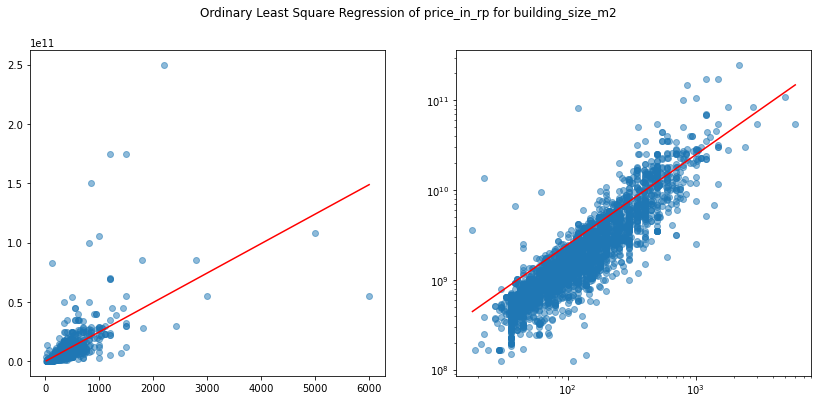

In [141]:
{"tags": ["hide-input"]}

# linear OLS
y_predict_1 = results_1.predict(X)
mse_1 = mean_squared_error(y, y_predict_1)
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X.building_size_m2, y, alpha=0.5)
    ax_.plot(
        np.sort(X.building_size_m2),
        y_predict_1[np.argsort(X.building_size_m2)], color='r',
        label=f'RMSE = {np.sqrt(mse_1)}'
        )
ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.suptitle('Ordinary Least Square Regression of price_in_rp for building_size_m2')
plt.show()
 

The randomness/variability of $y$ along the regression line is somewhat increasing. Figure on the right side involves the same observations, but both $x$ and $y$ axis is `log-scaled`. That figure shows how `constant variance` should look like, not on what the left side shows.

However, figure on the right explains that linearity exist between our explanatory variable and our target variable, but don't be deceived by its equally spreaded (constance variance) response along the regression line because the actual result is the figure on the left.

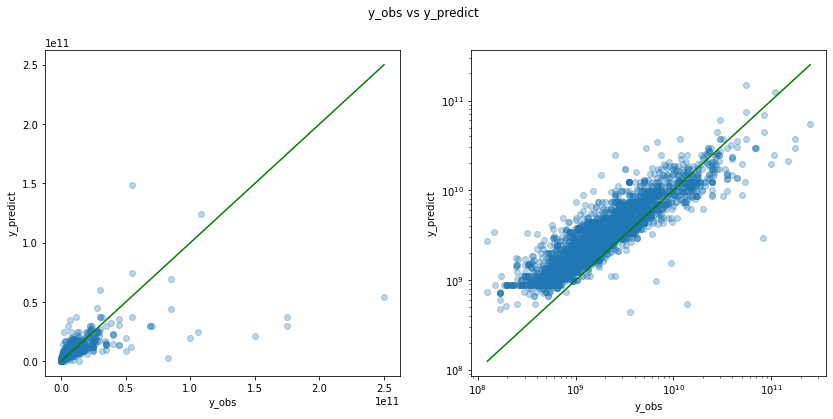

In [142]:
{"tags": ["hide-input"]}

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(x=y, y=y_predict_1, alpha=0.3)
    ax_.plot(np.sort(y), np.sort(y), color='g')
    ax_.set_xlabel('y_obs')
    ax_.set_ylabel('y_predict')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.suptitle('y_obs vs y_predict')
plt.show()

Above plot shows `actual observations` vs `linear model prediction`. Note that the spreading observations can also be identified on the left side plot above. Linear model that somewhat has ideal characteristic should be similar with what plot on the right side shows.

Green line represents $x=y=y_{obs}$, exact prediction line of $y_{obs}$. Our linear model seems to *overestimates* $y$ for lower house price.

#### **Residual Analysis of Simple Linear Regression**

Our next objective is to verify if our regression result conform with linear model concept about the normally distributed residual with constant variance. Let's take a look at residual plot along the $x$ variable:

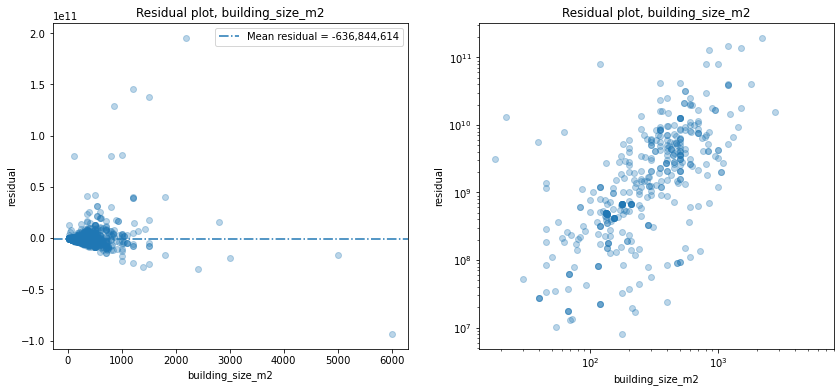

In [143]:
{"tags": ["hide-input"]}

resid_1 = y - y_predict_1
mean_resid_1 = np.mean(resid_1)
# matpltlib plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(x=X_train.building_size_m2.values.reshape(-1, 1), y=resid_1, alpha=0.3)
    ax_.axhline(
        y=resid_1.mean(), linestyle='-.',
        label=f'Mean residual = {mean_resid_1:,.0f}')
    ax_.set_title('Residual plot, building_size_m2')
    ax_.set_xlabel('building_size_m2')
    ax_.set_ylabel('residual')
ax[0].legend()
ax[1].set_xscale('log') 
ax[1].set_yscale('log')
plt.show()

Figure on the left shows that residual is somewhat increasing in variability that associated with increasing `building size`. Figure on the right magnifies the *increasing pattern of residuals*, it shows positive residual on log-scaled axes.

Look at the mean of the residuals. It is clearly biased by almost half of billions rupiahs and violates the OLS errors assumption (zero mean).

How about the normality of residual's distribution?

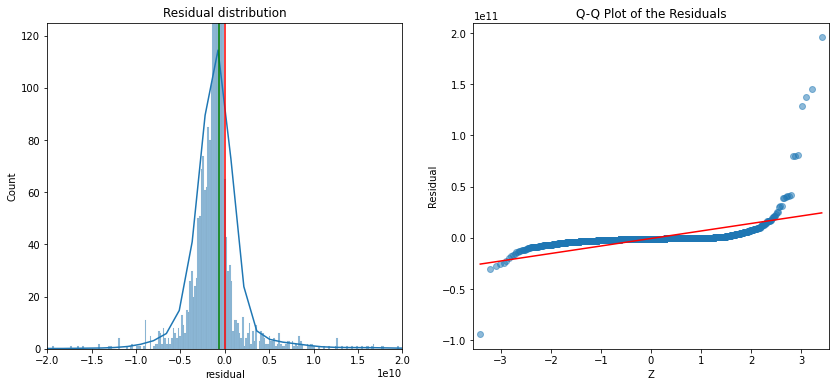

In [144]:
{"tags": ["hide-input"]}

from statsmodels.graphics.gofplots import ProbPlot

# ditribution of residual plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(x=resid_1, ax=ax[0], kde=True)
ax[0].set_title('Residual distribution')
ax[0].set_xlabel('residual')
ax[0].set_xlim(-2e10, 2e10)
ax[0].set_ylim(0, 125)
ax[0].axvline(color='red')
ax[0].axvline(mean_resid_1, color='green', label=f'Mean Residual, {mean_resid_1:,.2f}')
# Q-Q Plot
pplot = ProbPlot(resid_1)
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
ax[1].set_title('Q-Q Plot of the Residuals')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('Residual')
plt.show()

Red line on the left figure is vertical line which explains $residual = 0$. The distribution is rather *shifted to the left*, and since $residual = y_{obs} - y_{predict}$, it proves that, generally, our model **overestimate** the actual $y$. Therefore, it can be concluded that the residual is not located at 0. 

Figure on the right side is Q-Q plot of residual against standard normal distribution. If residual was normally distributed, the residual plots should be tightly positioned near the red line. This figure also proves that the distribution is quiet more fat-tailed than what normal distribution should.

Ordinary Least Square (OLS), according to Gauss-Markov Theorem, is *BLUE: Best Linear Unbiased Estimator*, when our model satisfies all of the six classical assumptions, including the *constant variance* assumption. *'Best'* refers to minimum variance or the narrowest sampling distribution. However, our dataset suffers from non-constant variance, what is commonly called, the presence of *heteroscedacity*. From above figure, it is clearly shown that **ordinary least square is a biased estimator for our dataset**.

We will use Breusch-Pagan test for heteroscedacity using below codes. The concept of Breusch-Pagan test is to estimate the auxillary regression, that is regression of the squared residuals on the predictor variable, then calculate the test statistic based on that regression. However, due to non-normality violation as explained above, actually below test is the Koenker's variant, which is robust to non-normal distribution. 

In [145]:
{"tags": ["hide-input"]}

from statsmodels.stats.diagnostic import het_breuschpagan

exog_het = X_train['building_size_m2'].values.reshape(-1, 1)
# since auxillary regression of residual 
# must have an intercept constant:
exog_het = add_constant(exog_het) 
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid_1, exog_het, robust=True)
pd.DataFrame({
    'statistic': ['lagrange multiplier', 'f'],
    'statistic_value': [lm, fvalue],
    'p_value': [lm_pvalue, f_pvalue]
    })

,statistic,statistic_value,p_value
0,lagrange multiplier,273.16,0.00
1,f,299.67,0.00


Above result **rejects the null hypotheses of homoscedacity**. `Weighted least square` can be a way to remedy this heteroscedacity condition.

#### **Dealing with Non-Constant Variance**

We will use `Weighted Least Square` to address non-constant variance in the data. For this dataset, we will use `Regression Robust to Heteroscedacity` provided in `\modules` directory, which developed according to {cite}`atkinson2016`, as follows:

$$Y=\beta_{i}\;x_i+\sigma_i\varepsilon_i$$

Errors $\varepsilon_i$ have a homoscedastic standard normal distribution $N(0, 1)$. Variance function $\sigma_i$ is dependent of variables responsible for heterscedascity, $Z$:

$$\sigma_i = Var\;y_i=\sigma^2(1+exp(z_i\gamma))$$

Sample weight is estimated using above parametric formula:

$$w_i=\sigma^2\;/\;\sigma_i^2=(g(z_i\gamma))^-1$$

The WLS model above explained as follows:  

Parameters will be estimated using least square, but here we want consider the sample noise $\varepsilon_i$ that is associated with $\sigma_i$, or in other words, noise terms will have large magnitudes when the variance is large. 

OLS cares equally about the error at each data point, which we don't favor for dataset **having variance that is constantly increasing** as the $x$ increase. This is because the regression line will be leveraged towards the high noise observations! To account for sample noise, here each sample will be weighted: when noise variance is large, it shall has small weight (and vice versa). This is why `sample weight` is proporsional to the `inverse of variance`. 

Mean square error, the cost function to be minimized, will becomes weighted for each sample as:

$$WMSE(b,\;w_1,...,\;w_n) = {\frac 1 n}\;\sum_{
    \begin{subarray}{l}1<i<n\end{subarray}
}w_i(y_i-x_ib)$$

After the sample weight is introduced, the Least Square estimate "tries harder" to match observations with large weights, and less hard to match them where the weights are small, conforms with what we expect for sample with large noise.

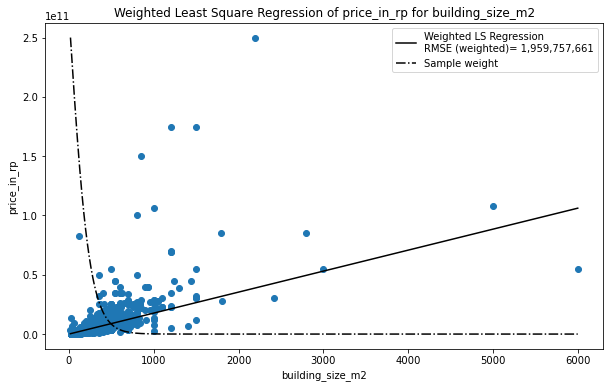

In [146]:
{"tags": ["hide-input"]}

X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
robust_reg = HetRobustRegression(fit_intercept=False)
# Weighted LS with full dataset
lm_2a = robust_reg.fit(X, y, X)
y_predict_2a = robust_reg.predict(X)
sample_weight_a = lm_2a.weight_
sample_weight_a_normlzd = \
    (sample_weight_a - np.min(sample_weight_a)) / (np.max(sample_weight_a) - np.min(sample_weight_a))
scaled_weight_a = sample_weight_a_normlzd * np.max(y)
mse_2a = mean_squared_error(y, y_predict_2a, sample_weight=sample_weight_a)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=X, y=y)
ax.plot(
    np.sort(X.flatten()), 
    y_predict_2a [np.argsort(X.flatten())], color='black',
    label=f'Weighted LS Regression\nRMSE (weighted)= {np.sqrt(mse_2a):,.0f}',
    )
ax.plot(
    np.sort(X.flatten()), 
    scaled_weight_a[np.argsort(X.flatten())], color='black',
    label='Sample weight', ls='-.'
    )
ax.set_title('Weighted Least Square Regression of price_in_rp for building_size_m2')
ax.set_xlabel('building_size_m2')
ax.set_ylabel('price_in_rp')
ax.legend()
plt.show()

Above figure shows the `weight trend` in dashed line. Here we can see the weight become much smaller, associated with increases in `building_size_m2`, and become near to zero right after the data visibly starts to spread.

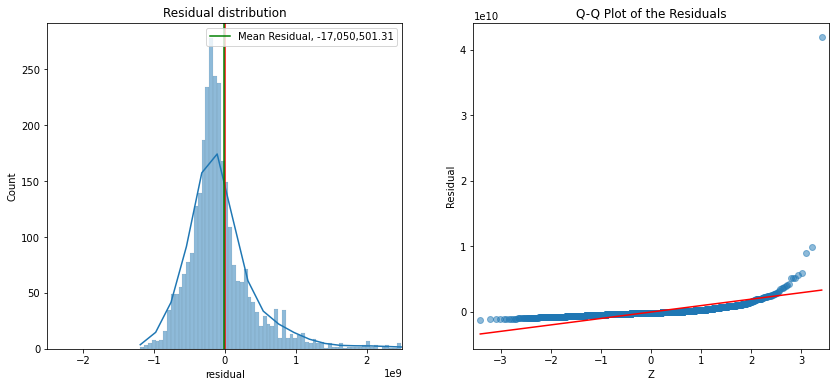

In [147]:
{"tags": ["hide-input"]}

resid_2a = np.sqrt(sample_weight_a) * (y - y_predict_2a)
mean_resid_2a = np.mean(resid_2a)
# ditribution of residual plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(x=resid_2a, ax=ax[0], kde=True)
ax[0].set_title('Residual distribution')
ax[0].set_xlabel('residual')
ax[0].set_xlim(-2.5e9, 2.5e9)
ax[0].axvline(color='red')
ax[0].axvline(mean_resid_2a, color='green', label=f'Mean Residual, {mean_resid_2a:,.2f}')
ax[0].legend()
# Q-Q Plot
pplot = ProbPlot(resid_2a)
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
ax[1].set_title('Q-Q Plot of the Residuals')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('Residual')
plt.show()

Residual mean drastically reduced compared to OLS model, and become closer to 0. Note that the Q-Q plot is also tighter to standard normal line.

Although it seems 'unfair' that we are using weighted residual, in section **3. Predictive Performance of Linear Model**, we will look at residual plot using test set.

In the next section, we will try to reduce the bias more by eliminating observations that possibly act as outliers in our dataset.

#### **Outliers Detection: Studentized Residual, Leverage Point, Cook Distance**

Standardized form of observation residual, or commonly denoted as studentized residual, can be used to detect if an observation is an outliers. This because *i*th *standardized residual* indicates how many standard deviations away that corresponding *i*th observation $y_i$ is from *i*th prediction $\hat{y_i}$.

By convention, the *i*th observation is said to have very large residual if $|e^*_i|>3$ ({cite}`devore2021`).

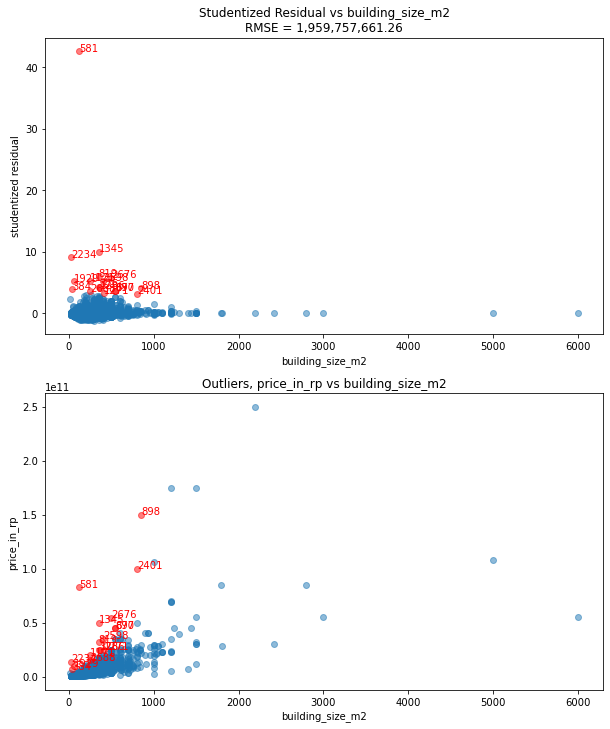

In [148]:
from scipy.sparse import diags

# Cook Distance
X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
W = diags(sample_weight_a)
p = X.shape[1] # no intercept
Xw = np.sqrt(W) @ X
yw = y * np.sqrt(sample_weight_a)
I = np.identity(len(y))
H = Xw @ np.linalg.inv((Xw.T) @ Xw) @ (Xw.T)
resid = (I - H) @ yw
se2 = np.square(np.linalg.norm(resid)) / (len(y) - p) # se2 = SSE / (n - p), p = 1 since no intercept
# leverage is (weighted) hat matrix diagonal
h = np.diag(H)
student_resid = resid / np.sqrt(se2 * (1 - h))
outlier_obs = (np.absolute(student_resid) > 3)
outlier_obs_index = np.where(outlier_obs)[0]
# plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
# Studentized Residual Plot
ax[0].scatter(x=X[~outlier_obs], y=student_resid[~outlier_obs], alpha=0.5)
ax[0].scatter(x=X[outlier_obs], y=student_resid[outlier_obs], alpha=0.5, color='r', label='Outliers')
for x, student_resid, index in np.c_[X[outlier_obs], student_resid[outlier_obs], outlier_obs_index]:
    ax[0].text(x=x, y=student_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('building_size_m2')
ax[0].set_title(f'Studentized Residual vs building_size_m2\nRMSE = {np.sqrt(mse_2a):,.2f}')
# Observations Plot
ax[1].scatter(x=X[~outlier_obs], y=y[~outlier_obs], alpha=0.5)
ax[1].scatter(x=X[outlier_obs], y=y[outlier_obs], alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[outlier_obs], y[outlier_obs], outlier_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('Outliers, price_in_rp vs building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')
plt.show()

In form of `Hat Matrix`, $H$, prediction of response $\hat{y_i}$ is $\hat{y}=Hy$ and therefore samplewise prediction:

$$\hat{y_i}=h_{1i}y_1 + ... + h_{ii}y_i+...+h_{in}y_n$$

The *i*th diagonal element of $H$, $h_{ii}$ measures the impact of *i*th observation $y_i$ on its own predicted $\hat{y_i}$ value, and sometimes called the **leverages** to indicate its impact on the regression.

An observation with very high leverage will tend to pull the regression toward it to make its residual small enough, recall that it is treated equally in minimizing cost function. High leverage observations is marked with observations that has *abnormally high values of predictor*, in our dataset it is the *kost* because the building size $6000\;m^2$ is far away from common house size that provided in the dataset.

There is a popular measure that accounts combination of *high-leveraged observations* and *high standardized residual*, it is **Cook's Distance**. Below codes calculate the `cook's distance` of each observations and mark the high-influence observations to be ignored.

(0.0, 2000.0)

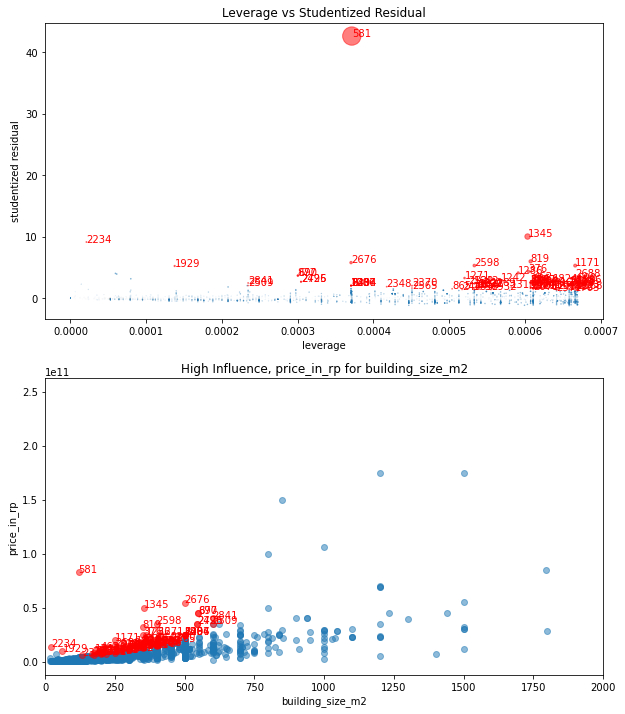

In [149]:
# Cook Distance
X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
W = diags(sample_weight_a)
p = X.shape[1] # no intercept
Xw = np.sqrt(W) @ X
yw = y * np.sqrt(sample_weight_a)
I = np.identity(len(y))
H = Xw @ np.linalg.inv((Xw.T) @ Xw) @ (Xw.T)
resid = (I - H) @ yw
se2 = np.square(np.linalg.norm(resid)) / (len(y) - p) # se2 = SSE / (n - p), p = 1 since no intercept
# leverage is (weighted) hat matrix diagonal
h = np.diag(H)
student_resid = resid / np.sqrt(se2 * (1 - h))
cooks_dist = (np.square(resid) / (p * se2)) * (h / np.square(1 - h))
high_influence_obs = (cooks_dist >= (3 / (X.shape[0] - p)))
high_influence_obs_index = np.where(high_influence_obs)[0]
# High Influence Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=h[~high_influence_obs], y=student_resid[~high_influence_obs], 
    s= cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[0].scatter(
    x=h[high_influence_obs], y=student_resid[high_influence_obs], 
    alpha=0.5, color='r', s=cooks_dist[high_influence_obs] * 500,
    label='high influence')
for lev, stud_resid, index in np.c_[
    h[high_influence_obs], student_resid[high_influence_obs], high_influence_obs_index]:
    ax[0].text(x=lev, y=stud_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('leverage')
ax[0].set_title('Leverage vs Studentized Residual')
# Observations Plot
ax[1].scatter(
    x=X[~high_influence_obs], y=y[~high_influence_obs], alpha=0.5)
ax[1].scatter(
    x=X[high_influence_obs], y=y[high_influence_obs], 
    alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[high_influence_obs], y[high_influence_obs], high_influence_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('High Influence, price_in_rp for building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')
ax[1].set_xlim(0, 2000)

Note that our weighted least square doesn't identify larger `building_size_m2` as a high influence, since it already considered them as their weight. The estimator now focuses more closer to higher-weighted samples (i.e. small `building_size_m2`). Look at some of the index that are presented in previous `outliers marker` are also shown in above. 

Now let's finalize our model to exclude those high influence observations.

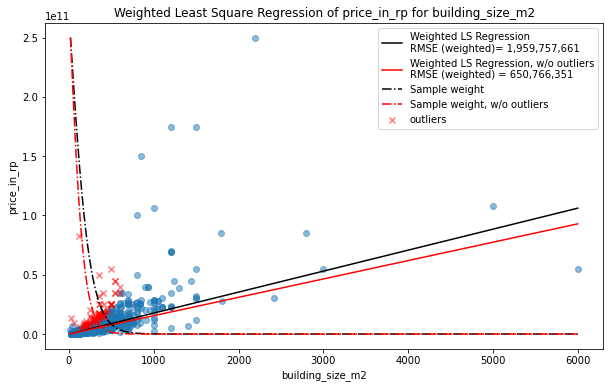

In [150]:
X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
# Weighted OLS without outliers
lm_2b = robust_reg.fit(X[~high_influence_obs], y[~high_influence_obs], X[~high_influence_obs])
y_predict_2b = robust_reg.predict(X[~high_influence_obs])
sample_weight_b = lm_2b.weight_
sample_weight_b_normlzd = \
    (sample_weight_b - np.min(sample_weight_b)) / (np.max(sample_weight_b) - np.min(sample_weight_b))
scaled_weight_b = sample_weight_b_normlzd * np.max(y)
mse_2b = mean_squared_error(y[~high_influence_obs], y_predict_2b, sample_weight=sample_weight_b)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=X[~high_influence_obs], y=y[~high_influence_obs], alpha=0.5)
ax.scatter(
    x=X[high_influence_obs], y=y[high_influence_obs], 
    marker='x', color='r',alpha=0.5, label='outliers'
    )
ax.plot(
    np.sort(X.flatten()), 
    y_predict_2a[np.argsort(X.flatten())], color='black',
    label=f'Weighted LS Regression\nRMSE (weighted)= {np.sqrt(mse_2a):,.0f}',
    )
ax.plot(
    np.sort(X[~high_influence_obs].flatten()), 
    y_predict_2b[np.argsort(X[~high_influence_obs].flatten())], color='red',
    label=f'Weighted LS Regression, w/o outliers\nRMSE (weighted) = {np.sqrt(mse_2b):,.0f}',
    )
ax.plot(
    np.sort(X.flatten()), 
    scaled_weight_a[np.argsort(X.flatten())], color='black',
    label='Sample weight', ls='-.'
    )
ax.plot(
    np.sort(X[~high_influence_obs].flatten()), 
    scaled_weight_b[np.argsort(X[~high_influence_obs].flatten())], color='red',
    label='Sample weight, w/o outliers', ls='-.'
    )
ax.set_title('Weighted Least Square Regression of price_in_rp for building_size_m2')
ax.set_xlabel('building_size_m2')
ax.set_ylabel('price_in_rp')
ax.legend()
plt.show()

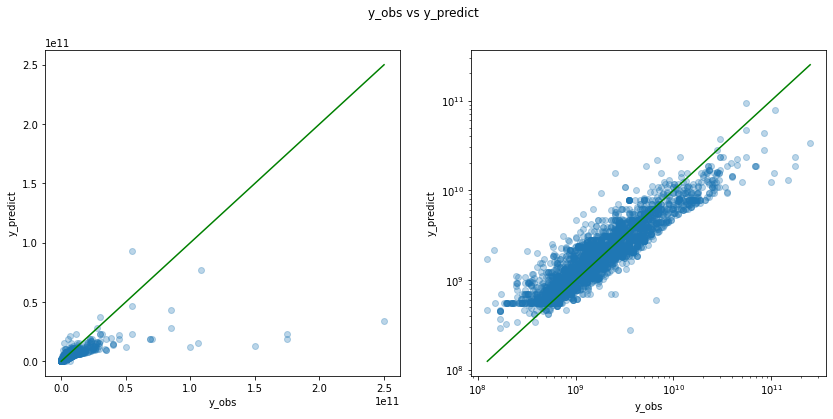

In [151]:
{"tags": ["hide-input"]}

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(x=y[~high_influence_obs], y=y_predict_2b, alpha=0.3)
    ax_.plot(np.sort(y[~high_influence_obs]), np.sort(y[~high_influence_obs]), color='g')
    ax_.set_xlabel('y_obs')
    ax_.set_ylabel('y_predict')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.suptitle('y_obs vs y_predict')
plt.show()

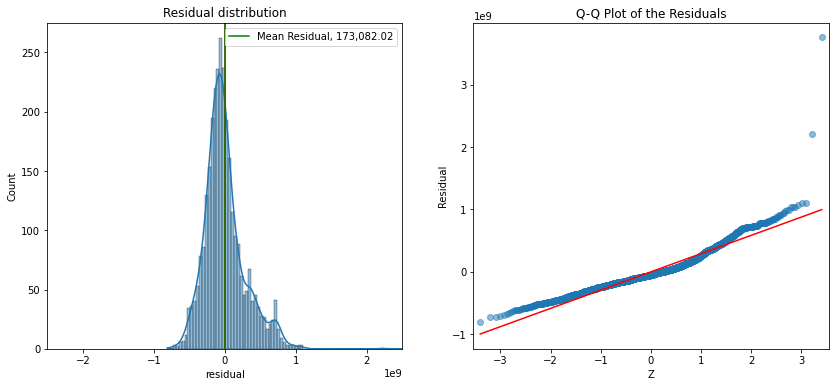

In [152]:
{"tags": ["hide-input"]}

resid_2b = np.sqrt(sample_weight_b) * (y[~high_influence_obs] - y_predict_2b)
mean_resid_2b = np.mean(resid_2b)
# ditribution of residual plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(x=resid_2b, ax=ax[0], kde=True)
ax[0].set_title('Residual distribution')
ax[0].set_xlabel('residual')
ax[0].set_xlim(-2.5e9, 2.5e9)
ax[0].axvline(color='red')
ax[0].axvline(mean_resid_2b, color='green', label=f'Mean Residual, {mean_resid_2b:,.2f}')
ax[0].legend()
# Q-Q Plot
pplot = ProbPlot(resid_2b)
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
ax[1].set_title('Q-Q Plot of the Residuals')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('Residual')
plt.show()

The result is improved, the residual becomes closer to zero mean and tighter to normality, although a bit positively skewed.

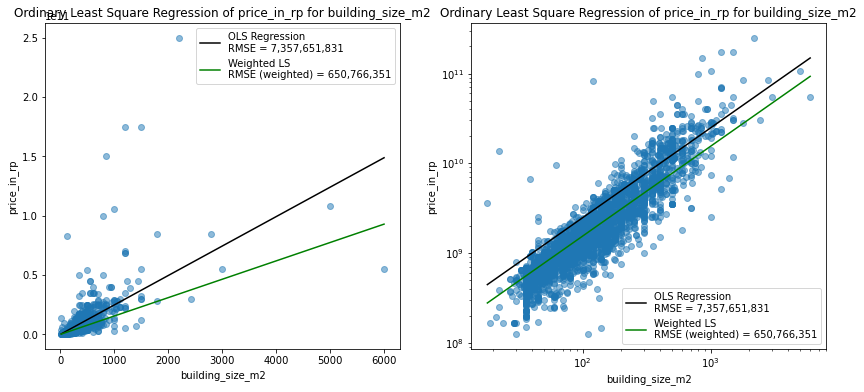

In [153]:
{"tags": ["hide-input"]}

X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X, y, alpha=0.5)
    ax_.plot(
        np.sort(X),
        y_predict_1[np.argsort(X)], color='black',
        label=f'OLS Regression\nRMSE = {np.sqrt(mse_1):,.0f}'       
        )
    ax_.plot(
        np.sort(X[~high_influence_obs].flatten()), 
        y_predict_2b[np.argsort(X[~high_influence_obs].flatten())], color='green',
        label=f'Weighted LS\nRMSE (weighted) = {np.sqrt(mse_2b):,.0f}',
    )  
    ax_.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
    ax_.legend()
    ax_.set_xlabel('building_size_m2')
    ax_.set_ylabel('price_in_rp')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

#### **Inference of `building_size_m2` parameter  and `mean response`**

In order to analyze the precision of our coefficient estimate, the inference will be performed by identifying its confidence interval. Quite narrow interval suggest that dataset gives the reasonable precise knowledge of the parameter.

Due to the presence of heterscedacity, a regular standard error is not valid to be used. Some remedies exist, for example, using a `robust covariance matrix`, but sometimes can also be biased in the presence of observations with high leverage {cite}`flachaire2003`.

Also according to {cite:t}`flachaire2003`, there is `wild bootstrap` which is proven robust to heteroscedacity hence performs better than using `robust covariance matrix`. This is because the DGP involves resampling that 'obey' the variance from individual residuals, explained in equation below:

$$y^*_t=X_t+\tilde{u}_t\epsilon^*_t$$

The heteroscedacity in bootstrap DGP is controlled by *restricted residual* $\tilde{u_t}$, the only variability is from resampling white noise $\epsilon^*_t$. White noise is resampled from uniformly distributed:

$$\epsilon^*_t=1\;or\;-1$$
$$Pr(\epsilon^*_t=1)=Pr(\epsilon^*_t=-11)=0.5$$

According to {cite:t}`davidson1993`, since we introduce *zero intercept* the residual shall be mean-corrected before being used to simulate random errors.

In [154]:
{"tags": ["hide-input"]}

def coefficient(x, y_null, boot_resid):
    epsilon = np.random.choice([1, -1], len(y_null), p=[0.5, 0.5]) # Flachair's pick distribution
    boot_resid_ = boot_resid.flatten()
    resid_dgp = boot_resid_ * epsilon
    y_dgp = (y_null + resid_dgp).flatten()
    lm_boots = OLS(y_dgp, x)
    result_boots = lm_boots.fit()
    coef_boots = result_boots.params[0]
    return coef_boots

X = X_train['building_size_m2'].values.reshape(-1, 1)[~high_influence_obs]
y = y_train['price_in_rp'].values[~high_influence_obs]
# prediction
lm = HetRobustRegression(fit_intercept=False)
results = lm.fit(X, y, X)
y_predict = results.predict(X) # y_predict here serves beta as the null hypotheses for bootstrap
coef = results.coef_
# calculate hat matrix
h = np.diag(X @ np.linalg.inv((X.T) @ X) @ (X.T)) #  = h_t in Flachair (2003)
# calculate adjusted residual
residual = y - y_predict # = OLS restricted residuals in Flachair (2003)
a = 1/ (1 - h) # using HC3 as proposed by Flachair (2003)
resid = a * residual
adj_resid = resid - np.mean(resid)
# bootstrap
arr = np.empty(len(y))
sample = (arr, )
confidence_level = 0.95
lower_tail = (1 - confidence_level) / 2
upper_tail = 1 - lower_tail 
bootstrap_res = bootstrap(
    sample, lambda arr: coefficient(X, y_predict, adj_resid), vectorized=False, 
    confidence_level=confidence_level, method='percentile'
)
pd.DataFrame([
    {'model': 'Weighted OLS, w/o outliers', 
    'coef': coef[0],
    f'ci_low ({lower_tail:.3f})': bootstrap_res.confidence_interval[0],
    f'ci_high({upper_tail:.3f})': bootstrap_res.confidence_interval[1],
    'bootstrap_se': bootstrap_res.standard_error}
    ])

,model,coef,ci_low (0.025),ci_high(0.975),bootstrap_se
0,"Weighted OLS, w/o outliers","15,490,373.55","11,090,920.92","19,963,808.77","2,360,788.32"


The interval doesn't include 0, therefore in 95% confidence limit, **the `building_size_m2` is a statistically significant parameter of linear regression. The estimate value is Rp. 15,490,373 with margin of error less than 5,000,000.**

Compare it to interval calculated using *student's t distribution* based on standard error of the coefficient:

In [155]:
{"tags": ["hide-input"]}

results_1.summary(alpha=0.05).tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
building_size_m2,2.481e+07,4.23e+05,58.728,0.000,2.4e+07,2.56e+07


For large sample, it is known that inference of regression coefficient *using student's t-distribution* will covers the *violation of normality* since *t-distribution will converge to normal*, but we won't know for sure how large of `n sample` is large enough for our dataset. But what is known that the largeness of `n` is highly affected by dataset skewness, in which our dataset suffers highly. Our model with `building_size_m2` also suffers from `non-constant variance`, which also affect the validity of our *t-distribution*.

The confidence interval is quite narrow (compared to the bootstrap result). The safer choice will be the `bootstrap confidence interval` due to reasons above.

As we hope that the bootstrap result portrays the true distribution of coefficient onfidently (we followed wild bootstrap method to achieve unbiased regression DGP and we assume that the dataset covers the population data well enough), the possibility of `building_size_m2` value can be identified by using below bootstrap plot.

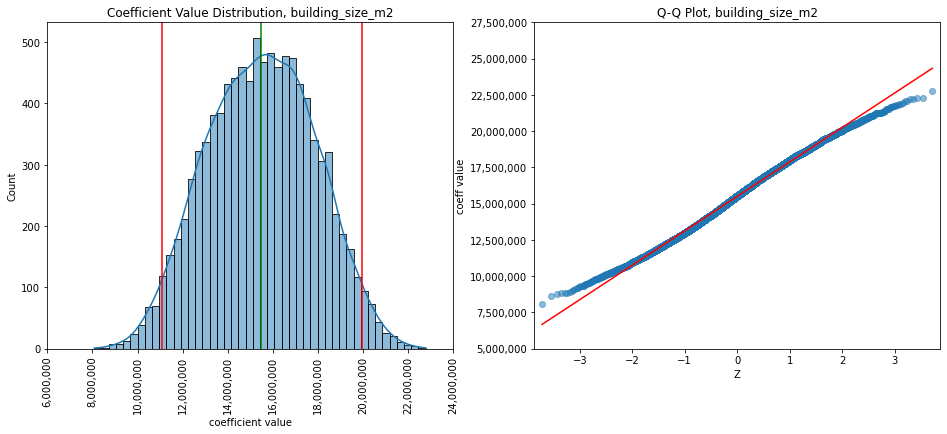

In [156]:
{"tags": ["hide-input"]}

X = X_train['building_size_m2'].values.reshape(-1, 1)[~high_influence_obs]
y = y_train['price_in_rp'].values[~high_influence_obs]
# prediction
lm = HetRobustRegression(fit_intercept=False)
results = lm.fit(X, y, X)
y_predict = results.predict(X) # y_predict here serves beta as the null hypotheses for bootstrap
coef = results.coef_
# calculate hat matrix
h = np.diag(X @ np.linalg.inv((X.T) @ X) @ (X.T)) #  = h_t in Flachair (2003)
# calculate adjusted residual
residual = y - y_predict # = OLS restricted residuals in Flachair (2003)
a = 1/ (1 - h) # using HC3 as proposed by Flachair (2003)
resid = a * residual
adj_resid = resid - np.mean(resid)
# bootstrapping
n_iter = 9999
arr = np.empty((n_iter, 1))
bootstrap_coeff_value = \
    np.apply_along_axis(lambda x: coefficient(X, y_predict, resid), 1, arr)
# plotting bootstrap result
conf_low = bootstrap_res.confidence_interval[0]
conf_high = bootstrap_res.confidence_interval[1]
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(
    x=bootstrap_coeff_value, kde=True, ax=ax[0]
    )
ax[0].axvline(coef[0], color='g')
ax[0].axvline(conf_low, color='r')
ax[0].axvline(conf_high, color='r')
xticks = ax[0].get_xticks()
ax[0].set_title('Coefficient Value Distribution, building_size_m2')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(['{:,.0f}'.format(x) for x in xticks], rotation=90)
ax[0].set_xlabel('coefficient value')
# Q-Q Plot
pplot = ProbPlot(bootstrap_coeff_value.flatten())
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(['{:,.0f}'.format(y) for y in yticks])
ax[1].set_title('Q-Q Plot, building_size_m2')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('coeff value')
plt.show()

As seen above, the coefficient distribution is quite skewed, which not yet close to our `symmetric t-distribution` caused by incorrect t-distribution due to non-constant variance. 

Although the Q-Q plot is tight to the normality, the distribution is fat-tailed, in which the sample size effect doesn't quite make the distribution *converge to normality* yet.

Both the skewed and fat-tailed distribution will be considered in `BCa Corrected Interval` that has been calculated by using `scipy.stats.bootstrap` program, making the `bootstrap ci` resulting in the more confidence choice of CI calculation.

Since our regression formula `y = 15,490,373 * X` here gives `conditional mean of price_price_in_rp at particular building_size_m2: mean y given X=x*`, confidence interval of X parameter will able to provide ` inference of mean y at 95% confidence level`.

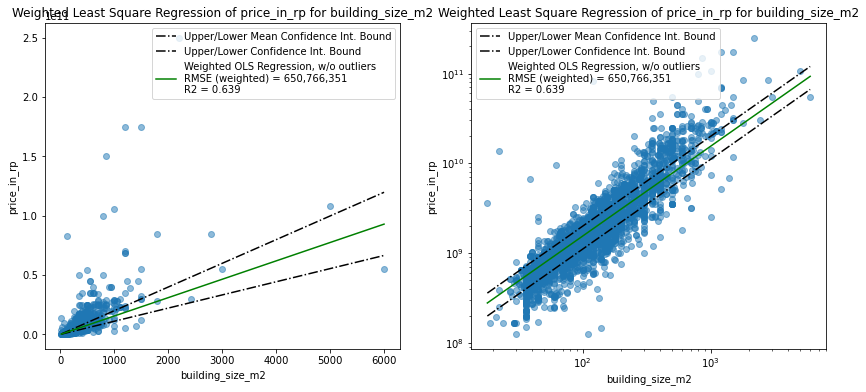

In [157]:
{"tags": ["hide-input"]}

X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
low_ci = (X * conf_low)
high_ci = (X * conf_high)
r2 = lm_2b.score(
    X[~high_influence_obs].reshape(-1, 1), 
    y[~high_influence_obs],
    X[~high_influence_obs].reshape(-1, 1))
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X, y, alpha=0.5)
    ax_.plot(
        np.sort(X),
        high_ci[np.argsort(X)], color='black', ls='-.',
        label='Upper/Lower Mean Confidence Int. Bound'       
    )
    ax_.plot(
        np.sort(X),
        low_ci[np.argsort(X)], color='black', ls='-.',
        label='Upper/Lower Confidence Int. Bound'       
    )
    ax_.plot(
        np.sort(X[~high_influence_obs].flatten()), 
        y_predict_2b[np.argsort(X[~high_influence_obs].flatten())], color='green',
        label=\
            'Weighted OLS Regression, w/o outliers'
            f'\nRMSE (weighted) = {np.sqrt(mse_2b):,.0f}'
            f'\nR2 = {r2:.3f}'
    )  
    ax_.set_title('Weighted Least Square Regression of price_in_rp for building_size_m2')
    ax_.legend()
    ax_.set_xlabel('building_size_m2')
    ax_.set_ylabel('price_in_rp')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

#### **Prediction Interval of Simple Regression**

Prediction interval of a linear regression is an interval of plausible values of future Y at a specific value of parameter x*, which accounts for ***variance of mean response Y caused by variability of regression coefficient which accounted in regression model**, and **variability caused by error term which can't be explained in regression model***. 

Recall from previous section, our *R2* value for this model is 0.639, explains that there were variability that can't be explained by the simple linear model. Plot of *Y_obs vs Y_predicted* also shows unexplained variance of the response by using only `building_size_m2`.

The error term variability can also be seen in residual plot, where the residual is quite condensed in small `building_size_m2` but continue to spread out in large `building_size_m2`.

Theoretical prediction interval of OLS relies heavily on *normality assumption* and *constant variance*, which is violated by our simple linear model.

Let's see the calculated prediction interval by our Simple Linear Model, which is simply calculated by assumming the normality and constant variance is valid.

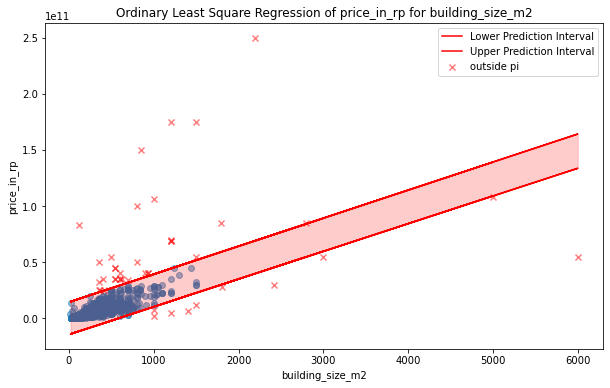

In [158]:
{"tags": ["hide-input"]}

X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, X)
results = lm.fit()
y_predict = results.get_prediction(X).summary_frame(0.05)
pi_lower = y_predict.obs_ci_lower
pi_upper = y_predict.obs_ci_upper
outside_pi = np.logical_or(y > pi_upper, y < pi_lower)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    x=X[~outside_pi], 
    y=y[~outside_pi], alpha=0.5
    )
ax.scatter(
    x=X[outside_pi], 
    y=y[outside_pi], alpha=0.5,
    color='red', marker='x',label='outside pi'
    )
ax.plot(X, pi_lower, color='r', label='Lower Prediction Interval')
ax.plot(X, pi_upper, color='r', label='Upper Prediction Interval')
ax.fill_between(
    x=np.sort(X), y1=pi_lower[np.argsort(X)], 
    y2=pi_upper[np.argsort(X)], alpha=0.2, color='r'
)
ax.set_xlabel('building_size_m2')
ax.set_ylabel('price_in_rp')
ax.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
ax.legend()
plt.show()

The variability of the response is not captured well on above standard prediction interval. If we consider the weighted model setting, figure below explains the prediction interval that accounts the sample variability. 

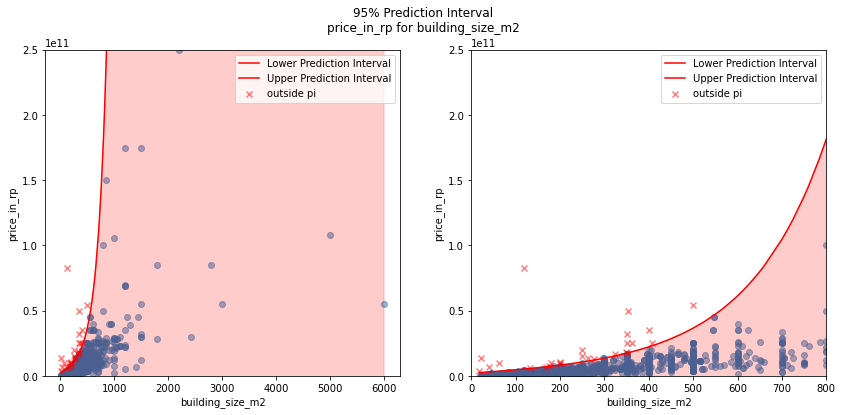

In [159]:
{"tags": ["hide-input"]}

from scipy.stats import norm

X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
# prediction
lm = HetRobustRegression(fit_intercept=False)
results = lm.fit(X[~high_influence_obs], y[~high_influence_obs], X[~high_influence_obs])
y_predict = results.predict(X)
weight = results.get_sample_weight(X)
W = diags(weight)
p = X.shape[1] # no intercept
Xw = np.sqrt(W) @ X
yw = y * np.sqrt(weight)
I = np.identity(len(y))
H = Xw @ np.linalg.inv((Xw.T) @ Xw) @ (Xw.T)
resid = (I - H) @ yw
sigma2 = np.square(np.linalg.norm(resid)) / (len(y) - p)
sigma2i = sigma2 * np.power(weight, -1)
interval = norm().interval(0.95)
resid_lower = np.sqrt(sigma2i) * interval[0]
resid_upper = np.sqrt(sigma2i) * interval[1]
pi_lower = y_predict + resid_lower
pi_upper = y_predict + resid_upper
outside_pi = np.logical_or(y >= pi_upper, y <= pi_lower)
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(
        x=np.sort(X.flatten()[~outside_pi]), 
        y=y[~outside_pi][np.argsort(X.flatten()[~outside_pi])], alpha=0.5
        )
    ax_.scatter(
        x=np.sort(X.flatten()[outside_pi]), 
        y=y[outside_pi][np.argsort(X.flatten()[outside_pi])], alpha=0.5,
        color='red', marker='x', label='outside pi'
        )
    ax_.plot(np.sort(X.flatten()), pi_lower[np.argsort(X.flatten())], color='r', label='Lower Prediction Interval')
    ax_.plot(np.sort(X.flatten()), pi_upper[np.argsort(X.flatten())], color='r', label='Upper Prediction Interval')
    ax_.fill_between(
        x=np.sort(X.flatten()), 
        y1=pi_lower[np.argsort(X.flatten())],
        y2=pi_upper[np.argsort(X.flatten())], 
        alpha=0.2, color='r'
    )
    ax_.set_xlabel('building_size_m2')
    ax_.set_ylabel('price_in_rp')
    ax_.set_ylim(0, np.max(y))
    ax_.legend()
fig.suptitle('95% Prediction Interval\nprice_in_rp for building_size_m2')    
ax[1].set_xlim(0, 800)
plt.show()

The prediction limit is increasing drastically after certain `building_size_m2` (around 500), suggests that there is a huge uncertainty when generalizing house price with building size larger than $500\;m^2$. Therefore, linear model that is developed using this dataset is realiable for building size $\leq\;500\;m^2$.

#### **Conclusion: Simple Linear Regression**

Simple linear regression using `building_size_m2` is proven to be statistically significant to generalize  Jabodetabek House Price. However, the model captures only about 60% of the variability that presents in the dataset. The variability of the dataset increases along with the increase of the building size. 

The linear model is representative to predict average house price in Jabodetabek with building size in interval $[18\;m^2,\;6000\;m^2]$. Increases of the building size by $1\;m^2$ will drive the house price higher by $(15,490,373)$. It should be known that, due to the variability, the model seems to give precision results only for building size no more than $500m^2$. 

## 3.2. Multiple Linear Regression

Multiple linear regression tries to involve more than 1 predictors, in the hope to increase the model coverage of variability that presents in the dataset.

Let's see our base multiple regression using all of the available features. Note that we will use `covariance matrix HC3 that robust to heteroscedacity` to quickly estimate robust standard error and cherry-picking the predictors that are statistically significant. Later we will use `heteroscedacity robust regression` and `wild bootstrap` to further improve our inference performance.

Recall from previous chapter, we have to exclude `Jakarta Pusat` in our analysis. Removing the predictor variable alone is not enough because the model still assume `Jakarta Pusat` as a base condition (equivalently with `Bekasi`, `Depok`, `Jakarta Timur`, `Jakarta Utara`) and the model will possibly be biased. We have to drop the observations as well!

In [160]:
{"tags": ["hide-input"]}

train_set_transfd = pd.merge(
    X_train, y_train, left_index=True, right_index=True
    )
jakpus_index = train_set_transfd[train_set_transfd.city == ' Jakarta Pusat'].index
train_set_transfd = train_set_transfd.drop(
    jakpus_index
    )
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category']).drop(['lat', 'long'], axis=1).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
f = 'price_in_rp ~ '\
    + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(certificate, Treatment(reference=3)) + ' # `SHM` as reference
f += 'C(property_condition, Treatment(reference=3)) + ' # `butuh renovasi` as reference
f += 'C(furnishing, Treatment(reference=2)) + '  # `unfurnished` as reference
f += 'C(city, Treatment(reference=0))' # `Bekasi` as reference

lm = OLS.from_formula(f, data=train_set_transfd)
results = lm.fit(cov_type='HC3')

What have we done using above codes?

1. We treat category variable using (k - 1) one-hot encoder, treating a value in a category as a reference. For example, `Bekasi` is a base reference for `city` predictor after it is encoded. Then, for example, the coefficient of encoded `Tangerang` is interpreted as **increase of mean response if `city` is `Tangerang` instead of `Bekasi`**.
2. Covariance type is set to `HC3`, set the OLS regression to consider robust covariance matrix. This is to ensure that we use the proper method of determining t-statistics for our parameter estimate. According to {cite:t}`flachair2006`, `HC3` performs better in finite sample and superior than any other in typical cases. 

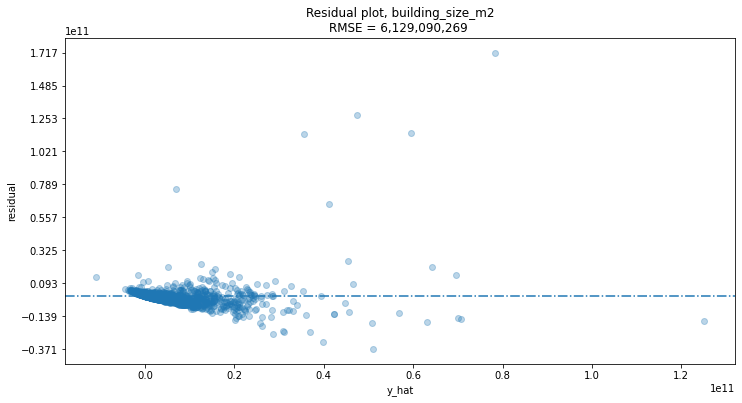

In [161]:
{"tags": ["hide-input"]}

y = train_set_transfd['price_in_rp'].values.flatten()
y_hat = results.predict(train_set_transfd)
resid = train_set_transfd.price_in_rp - y_hat
mse = mean_squared_error(y, y_hat)
# matpltlib plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=y_hat, y=resid, alpha=0.3)
ax.axhline(y=resid.mean(), linestyle='-.')
ax.set_title(f'Residual plot, building_size_m2\nRMSE = {np.sqrt(mse):,.0f} ')
ax.set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')
plt.show()

The presence of heteroscedacity can also be identified, because as shown in simple linear model the `building_size_m2` (and possibly `land_size_m2` which has similar characteristics) is responsible to heterscedacity. 

In [162]:
{"tags": ["hide-input"]}

results.summary().tables[0]

Dep. Variable:,price_in_rp,R-squared:,0.584
Model:,OLS,Adj. R-squared:,0.576
Method:,Least Squares,F-statistic:,nan
Date:,"Wed, 30 Nov 2022",Prob (F-statistic):,nan
Time:,13:56:04,Log-Likelihood:,-72824.
No. Observations:,3040,AIC:,1.458e+05
Df Residuals:,2980,BIC:,1.461e+05
Df Model:,59,,
Covariance Type:,HC3,,


For multiple regression, it is best to use `adjusted R-squared`, because regular $R^2$ tends to be inflated by involvement of many predictor variables {cite}`devore2021`. The $R^2$ is inferior compared to our simple WLS model possibly because so many predictors are involved and most of them are statistically insignificant.

#### **Multicollinearity**

Collinearity between predictor variables can mask the importance of a variable that is collinear with such. In multiple regression setting with high degree of predictor variables, it is also possible for collinearity to exist between three or more variables even if no pair of variables has a particularly high correlation, which is called *multicollinearity*.

The `VIF` (variance inflation factor) is known to be a better way to assess mulicollinearity. The VIF is the ratio of the variance of $\hat{\beta_j}$ when fitting the full model divided by the variance of $\hat{\beta_j}$ if fit on its own. The smallest possible value for VIF is 1, which indicates the complete absence of collinearity. VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity {cite}`jamesetal2021`.

In [163]:
{"tags": ["hide-input"]}

from statsmodels.stats.outliers_influence import variance_inflation_factor

# We need to encode categorical variable first
dummy_reference = [
    'city_ Bekasi', 'furnishing_unfurnished', 
    'property_condition_butuh renovasi', 'certificate_shm - sertifikat hak milik']
X_train = X_train.drop(jakpus_index)
X_train_encoded = \
    pd.get_dummies(X_train, columns=categorical_features)\
        .drop(dummy_reference, axis=1)\
        .drop(['lat', 'long'], axis=1)
pd.DataFrame({
    'vif': 
        [variance_inflation_factor(X_train_encoded, i) for i in range(X_train_encoded.shape[1])]
    },
    index=X_train_encoded.columns
    ).sort_values(by='vif', ascending=False).T

d:\anaconda3\envs\general_ds\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,fac_gudang,fac_basement,bedrooms,bathrooms,floors,fac_keamanan,property_condition_bagus,fac_garden,property_condition_baru,building_size_m2,maid_bedrooms,maid_bathrooms,electricity_num,fac_jogging_track,carports,city_ Tangerang,garages,fac_ac,city_ Bogor,property_condition_bagus sekali,fac_service_area,fac_lapangan_bulu_tangkis,fac_wastafel,fac_one_gate_system,fac_lapangan_voli,fac_tempat_jemuran,fac_lapangan_basket,fac_playground,fac_kulkas,fac_cctv,fac_masjid,fac_jalur_telepon,fac_lapangan_tenis,fac_water_heater,fac_kitchen_set,land_size_m2,fac_mesin_cuci,fac_kolam_renang,city_ Depok,fac_garasi,fac_tempat_gym,furnishing_semi furnished,fac_akses_parkir,city_ Jakarta Selatan,fac_lapangan_bola,property_condition_sudah renovasi,fac_smart_home,fac_backyard_luas,fac_plumbing_system,city_ Jakarta Barat,city_ Jakarta Utara,furnishing_furnished,"certificate_lainnya (ppjb,girik,adat,dll)",city_ Jakarta Timur,certificate_hgb - hak guna bangunan,fac_kolam_ikan,fac_canopy,fac_balkon,fac_clubhouse,certificate_hp - hak pakai
vif,inf,inf,26.09,22.69,12.42,10.13,9.65,9.44,8.18,5.59,4.05,4.03,3.75,3.11,2.93,2.93,2.80,2.78,2.68,2.65,2.63,2.63,2.58,2.52,2.51,2.50,2.38,2.28,2.27,2.26,2.25,2.24,2.21,2.18,2.17,2.16,2.15,2.13,2.07,2.03,2.03,2.00,1.99,1.87,1.85,1.81,1.76,1.58,1.56,1.54,1.52,1.33,1.26,1.19,1.16,1.16,1.11,1.01,1.01,1.01


Infinite value of VIF shows a perfect correlation between two independent variables. Infinite value of VIF in above table involves `facilities` variable, specifically they have small amount of observations compared to 0 records of those facilities hence inflated the VIF. We will drop those variables accordingly.

It is common to re-calculate the VIF until the results is satisfied.

In [164]:
{"tags": ["hide-input"]}

high_vif_features = [
    'fac_basement', 'fac_gudang', 'bedrooms', 'bathrooms',
    'floors', 'fac_keamanan', 'fac_garden', 
    ]
dummy_reference = [
    'city_ Bekasi', 'furnishing_unfurnished', 
    'property_condition_butuh renovasi', 'certificate_shm - sertifikat hak milik']
X_train_encoded = \
    pd.get_dummies(X_train, columns=categorical_features)\
        .drop(dummy_reference, axis=1)\
        .drop(['lat', 'long'], axis=1)\
        .drop(high_vif_features, axis=1)
pd.DataFrame({
    'vif': 
        [variance_inflation_factor(X_train_encoded, i) for i in range(X_train_encoded.shape[1])]
    },
    index=X_train_encoded.columns
    ).sort_values(by='vif', ascending=False).T

,building_size_m2,property_condition_bagus,property_condition_baru,maid_bedrooms,maid_bathrooms,electricity_num,fac_jogging_track,carports,fac_ac,city_ Tangerang,fac_lapangan_bulu_tangkis,fac_wastafel,city_ Bogor,fac_one_gate_system,fac_lapangan_voli,fac_tempat_jemuran,fac_lapangan_basket,fac_playground,fac_kulkas,fac_cctv,fac_jalur_telepon,fac_lapangan_tenis,fac_masjid,garages,fac_water_heater,fac_kitchen_set,fac_mesin_cuci,fac_kolam_renang,land_size_m2,fac_tempat_gym,furnishing_semi furnished,fac_akses_parkir,city_ Depok,property_condition_bagus sekali,fac_lapangan_bola,city_ Jakarta Selatan,fac_smart_home,fac_service_area,fac_backyard_luas,city_ Jakarta Utara,city_ Jakarta Barat,fac_plumbing_system,fac_garasi,property_condition_sudah renovasi,furnishing_furnished,"certificate_lainnya (ppjb,girik,adat,dll)",city_ Jakarta Timur,certificate_hgb - hak guna bangunan,fac_kolam_ikan,fac_canopy,fac_balkon,fac_clubhouse,certificate_hp - hak pakai
vif,4.83,4.23,4.18,4.00,3.99,3.68,2.95,2.87,2.77,2.72,2.63,2.57,2.53,2.51,2.51,2.48,2.37,2.27,2.26,2.24,2.24,2.20,2.19,2.18,2.18,2.16,2.15,2.11,2.11,2.02,1.99,1.98,1.96,1.88,1.85,1.83,1.73,1.59,1.57,1.47,1.43,1.41,1.41,1.31,1.30,1.24,1.17,1.16,1.15,1.09,1.01,1.01,1.01


Based on our dataset, `building_size_m2` is highly correlated to `land_size_m2`. The model that involves only one of those variables is possibly as good as involving both variables. But if we use both, we may get a better result if there is an observation which has a significantly larger `land_size_m2` than `building_size_m2` (house located in rural area possibly has this situation), which is rarely found in our fitted dataset.

In [165]:
{"tags": ["hide-input"]}

high_vif_features = [
    'fac_basement', 'fac_gudang', 'bedrooms', 'bathrooms',
    'floors', 'fac_keamanan', 'fac_garden', 'lat', 'long'
]
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category']).drop(high_vif_features, axis=1).columns
f = 'price_in_rp ~ '\
    + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(certificate, Treatment(reference=3)) + ' # `SHM` as reference
f += 'C(property_condition, Treatment(reference=3)) + ' # `butuh renovasi` as reference
f += 'C(furnishing, Treatment(reference=2)) + '  # `unfurnished` as reference
f += 'C(city, Treatment(reference=0))' # `Bekasi` as reference

lm = OLS.from_formula(f, data=train_set_transfd)
results = lm.fit(cov_type='HC3')

#### **Features Significancy**

We will use predictors that only have small *p-value* i.e. is statistically significant.

In [166]:
{"tags": ["hide-input"]}

results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
"C(certificate, Treatment(reference=3))[hgb - hak guna bangunan]",-3.82e+08,2.38e+09,-0.160,0.873,-5.05e+09,4.29e+09
"C(certificate, Treatment(reference=3))[hp - hak pakai]",1.246e+09,2.44e+09,0.510,0.610,-3.54e+09,6.03e+09
"C(certificate, Treatment(reference=3))[lainnya (ppjb,girik,adat,dll)]",1.197e+08,2.28e+09,0.052,0.958,-4.35e+09,4.59e+09
"C(certificate, Treatment(reference=3))[shm - sertifikat hak milik]",1.53e+08,2.3e+09,0.066,0.947,-4.36e+09,4.66e+09
"C(property_condition, Treatment(reference=3))[T.bagus]",-2.244e+09,2.26e+09,-0.994,0.320,-6.67e+09,2.18e+09
"C(property_condition, Treatment(reference=3))[T.bagus sekali]",-3.257e+09,2.32e+09,-1.402,0.161,-7.81e+09,1.3e+09
"C(property_condition, Treatment(reference=3))[T.baru]",-1.774e+09,2.26e+09,-0.784,0.433,-6.21e+09,2.66e+09
"C(property_condition, Treatment(reference=3))[T.sudah renovasi]",-2.877e+09,2.27e+09,-1.270,0.204,-7.32e+09,1.56e+09
"C(furnishing, Treatment(reference=2))[T.furnished]",-1.17e+09,6.28e+08,-1.864,0.062,-2.4e+09,6e+07
"C(furnishing, Treatment(reference=2))[T.semi furnished]",-5.87e+08,4.21e+08,-1.395,0.163,-1.41e+09,2.38e+08


Let's observe above output:
1. `Certificate` features has a high p-value, meaning that there is no significance evidence that `price_in_rp` will be associated with different type of certificate. It is also identified for `property_condition` and `furnishing` parameter. This proves our point in previous chapter.
2. `maid_bedrooms` has a low p-value but gives a high coefficient value since it is inflated by observations with high `price_in_rp` (larger house tends to provide maid_bedrooms). While this condition is proven by our data, however it is less essential to be our main parameter for generalization since it is biased only for large house so I just drop this features.
3. We expect positive values for `facilities` parameters. However some of them has negative value, means that they only `adjusting` for other parameters since it is lacking of coverage along overall price range. This will reduce our generalization so I will drop those parameters. For `positive coefficient value` of other facilities : [`fac_kolam_renang`, `fac_akses_parkir`, `fac_canopy`], we will keep that and let's see how they will be adjusted after other coefficient primary.
4. `Jakarta Utara` has a significantly high coefficient value, but its p-value is also high. Recall from previous chapter, `Jakarta Utara` is among the highest median of all DKI Jakarta and has a narrow confidence interval (unlike `Jakarta Pusat` which has large spread!). We will keep this feature first and let's see how this feature change if we adjust other features 
5. For other features that has high pvalue will be dropped.

In [167]:
from patsy import dmatrices

high_pvalue_features = [
    'fac_tempat_jemuran', 'fac_jogging_track', 'fac_jalur_telepon', 'fac_jogging_track', 'fac_masjid', 
    'fac_cctv', 'fac_kitchen_set', 'fac_playground', 'fac_wastafel', 'fac_ac', 'fac_lapangan_bola', 
    'fac_mesin_cuci', 'fac_lapangan_bulu_tangkis', 'fac_kulkas', 'fac_water_heater', 'fac_smart_home', 
    'fac_backyard_luas', 'fac_garasi', 'fac_balkon', 'fac_clubhouse', 'fac_service_area', 'fac_plumbing_system',
    'maid_bathrooms', 'maid_bedrooms', 'electricity_num'
]
noise_features = [
    'fac_one_gate_system', 'fac_tempat_gym', 'fac_kolam_ikan', 'fac_lapangan_voli', 'carports', 'garages',
    'fac_lapangan_basket', 'fac_lapangan_tenis', 'fac_akses_parkir', 'fac_canopy'
]
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category'])\
        .drop(high_vif_features, axis=1)\
        .drop(high_pvalue_features, axis=1)\
        .drop(noise_features, axis=1).columns
f = 'price_in_rp ~ ' + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(city)'
y, X = dmatrices(f, train_set_transfd, return_type='dataframe')
X = X.drop(X.columns[[0]], axis=1) # `Bekasi` as reference
y = y.values.flatten()
lm = OLS(y, X)
results = lm.fit(cov_type='HC3')
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
C(city)[ Bogor],-2.08e+09,6.62e+08,-3.143,0.002,-3.38e+09,-7.83e+08
C(city)[ Depok],-1.197e+09,3.65e+08,-3.284,0.001,-1.91e+09,-4.83e+08
C(city)[ Jakarta Barat],-5.726e+08,9.89e+08,-0.579,0.562,-2.51e+09,1.36e+09
C(city)[ Jakarta Selatan],4.87e+09,1.32e+09,3.699,0.000,2.29e+09,7.45e+09
C(city)[ Jakarta Timur],-9.226e+08,4.83e+08,-1.910,0.056,-1.87e+09,2.39e+07
C(city)[ Jakarta Utara],2.039e+09,1.92e+09,1.062,0.288,-1.72e+09,5.8e+09
C(city)[ Tangerang],-1.008e+09,5.77e+08,-1.745,0.081,-2.14e+09,1.24e+08
land_size_m2,5.278e+06,2.57e+06,2.052,0.040,2.36e+05,1.03e+07
building_size_m2,1.822e+07,4.21e+06,4.326,0.000,9.97e+06,2.65e+07
fac_kolam_renang,1.05e+09,3.42e+08,3.069,0.002,3.8e+08,1.72e+09


A lot of negative coefficient of `city` shows that `Bekasi` may not be the city with lowest mean price. This is possibly caused by the similar average value of house price between those locations.

In [168]:
{"tags": ["hide-input"]}

train_set_transfd.groupby('city').aggregate({'price_in_rp':'mean'})

,price_in_rp
city,
Bekasi,"1,291,126,732.67"
Bogor,"2,511,373,844.12"
Depok,"1,263,725,108.23"
Jakarta Barat,"4,794,971,098.27"
Jakarta Selatan,"15,567,246,445.50"
Jakarta Timur,"2,023,294,871.79"
Jakarta Utara,"13,660,223,214.29"
Tangerang,"3,673,188,679.25"


The mean price between cities is similar except for `Jakarta Selatan` and `Jakarta Utara`:

1. `Jakarta Barat` and `Tangerang` has a bit higher price than `Bekasi`, `Bogor`, `Depok`. That is why their interval includes positive value of coefficient. Nevertheless, their interval includes 0 so we will drop them.
2. House located in `Jakarta Selatan` and `Jakarta Utara`, based on above, is believed to have a significantly higher price among others, so we will keep this features.

In [169]:
{"tags": ["hide-input"]}

high_pvalue_features = [
    'fac_tempat_jemuran', 'fac_jogging_track', 'fac_jalur_telepon', 'fac_jogging_track', 'fac_masjid', 
    'fac_cctv', 'fac_kitchen_set', 'fac_playground', 'fac_wastafel', 'fac_ac', 'fac_lapangan_bola', 
    'fac_mesin_cuci', 'fac_lapangan_bulu_tangkis', 'fac_kulkas', 'fac_water_heater', 'fac_smart_home', 
    'fac_backyard_luas', 'fac_garasi', 'fac_balkon', 'fac_clubhouse', 'fac_service_area', 'fac_plumbing_system',
    'maid_bathrooms', 'maid_bedrooms', 'electricity_num'
]
noise_features = [
    'fac_one_gate_system', 'fac_tempat_gym', 'fac_kolam_ikan', 'fac_lapangan_voli', 'carports', 'garages',
    'fac_lapangan_basket', 'fac_lapangan_tenis', 'fac_akses_parkir', 'fac_canopy'
]
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category'])\
        .drop(high_vif_features, axis=1)\
        .drop(high_pvalue_features, axis=1)\
        .drop(noise_features, axis=1).columns
f = 'price_in_rp ~ ' + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(city)'
y, X = dmatrices(f, train_set_transfd, return_type='dataframe')
X = X.drop(X.columns[[0, 1, 2, 3, 5, 7]], axis=1)
y = y.values.flatten()
lm = OLS(y, X)
results = lm.fit(cov_type='HC3')
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
C(city)[ Jakarta Selatan],5.931e+09,1.18e+09,5.010,0.000,3.61e+09,8.25e+09
C(city)[ Jakarta Utara],3.136e+09,1.35e+09,2.321,0.020,4.88e+08,5.78e+09
land_size_m2,4.739e+06,2.34e+06,2.026,0.043,1.54e+05,9.32e+06
building_size_m2,1.703e+07,3.31e+06,5.146,0.000,1.05e+07,2.35e+07
fac_kolam_renang,3.795e+08,4.96e+08,0.765,0.444,-5.92e+08,1.35e+09


Surprisingly `Jakarta Utara` now becomes significant! Hence our model assumes that house price in `Bekasi`, `Bogor`, `Depok`, `Tangerang`, `Jakarta Timur` and `Jakarta Barat` is similar.

The variability of `fac_kolam_renang` coefficient increases so we will drop this. Next thing to do is to apply proper Weighted Least Square and removing outliers.

In [170]:
{"tags": ["hide-input"]}

high_pvalue_features = [
    'fac_tempat_jemuran', 'fac_jogging_track', 'fac_jalur_telepon', 'fac_jogging_track', 'fac_masjid', 
    'fac_cctv', 'fac_kitchen_set', 'fac_playground', 'fac_wastafel', 'fac_ac', 'fac_lapangan_bola', 
    'fac_mesin_cuci', 'fac_lapangan_bulu_tangkis', 'fac_kulkas', 'fac_water_heater', 'fac_smart_home', 
    'fac_backyard_luas', 'fac_garasi', 'fac_balkon', 'fac_clubhouse', 'fac_service_area', 'fac_plumbing_system',
    'maid_bathrooms', 'maid_bedrooms', 'electricity_num', 'fac_kolam_renang'
]
noise_features = [
    'fac_one_gate_system', 'fac_tempat_gym', 'fac_kolam_ikan', 'fac_lapangan_voli', 'carports', 'garages',
    'fac_lapangan_basket', 'fac_lapangan_tenis', 'fac_akses_parkir', 'fac_canopy'
]
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category'])\
        .drop(high_vif_features, axis=1)\
        .drop(high_pvalue_features, axis=1)\
        .drop(noise_features, axis=1).columns
f = 'price_in_rp ~ ' + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(city)'
y, X = dmatrices(f, train_set_transfd, return_type='dataframe')
X = X.drop(X.columns[[0, 1, 2, 3, 5, 7]], axis=1)
features = X.columns
y = y.values.flatten()
lm = OLS(y, X)
results = lm.fit(cov_type='HC3')
results.summary().tables[0]

Dep. Variable:,y,R-squared (uncentered):,0.576
Model:,OLS,Adj. R-squared (uncentered):,0.576
Method:,Least Squares,F-statistic:,230.7
Date:,"Wed, 30 Nov 2022",Prob (F-statistic):,4.07e-173
Time:,13:56:11,Log-Likelihood:,-73083.
No. Observations:,3040,AIC:,1.462e+05
Df Residuals:,3036,BIC:,1.462e+05
Df Model:,4,,
Covariance Type:,HC3,,


#### **Optimizing Multiple Regression**

We will apply Weighted Least Square to estimate coefficient. Variables that are responsible to heterscedacity are `building_size_m2` and `land_size_m2`.

Text(0, 0.5, 'residual')

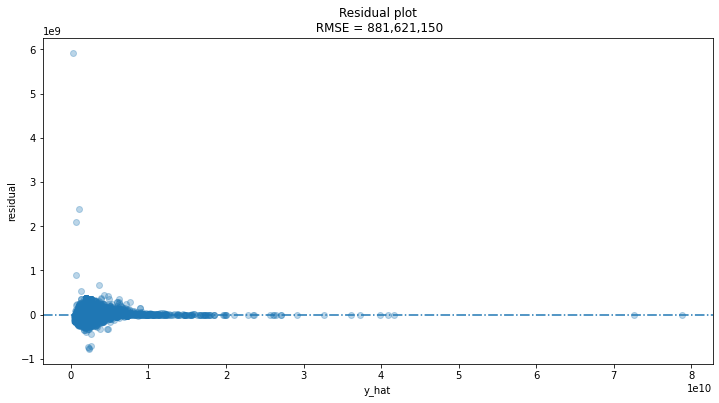

In [171]:
{"tags": ["hide-input"]}

X = X.values
Z = X[:, [2, 3]]# Variables responsible for heteroscedacity
# Robust Regression
reg = HetRobustRegression(fit_intercept=False)
results = reg.fit(X, y, Z)
y_hat = results.predict(X)
weight = results.weight_
weighted_resid = weight * (y - y_hat)
mse = mean_squared_error(y, y_hat, sample_weight=weight)
# matpltlib plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=y_hat, y=weighted_resid, alpha=0.3)
ax.axhline(y=weighted_resid.mean(), linestyle='-.')
ax.set_title(f'Residual plot\n RMSE = {np.sqrt(mse):,.0f}')
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')

As can be seen clearly on above figure, there are observations that act as outliers. We will use the same method that has already explained previously.

Text(0.5, 0, 'Obs. Number')

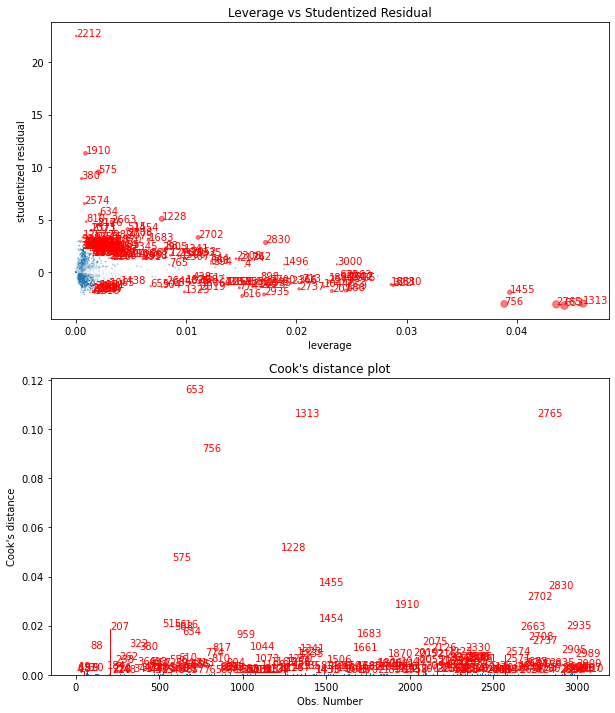

In [172]:
{"tags": ["hide-input"]}

# Cook Distance
W = diags(weight)
p = X.shape[1] # no intercept
Xw = np.sqrt(W) @ X
yw = y * np.sqrt(weight)
I = np.identity(len(y))
H = Xw @ np.linalg.inv((Xw.T) @ Xw) @ (Xw.T)
resid = (I - H) @ yw
se2 = np.square(np.linalg.norm(resid)) / (len(y) - p) # se2 = SSE / (n - p), p = 1 since no intercept
# leverage is (weighted) hat matrix diagonal
h = np.diag(H)
student_resid = resid / np.sqrt(se2 * (1 - h))
cooks_dist = (np.square(resid) / (p * se2)) * (h / np.square(1 - h))
high_influence_obs = (cooks_dist >= (3 / (X.shape[0] - p)))
high_influence_obs_index = np.where(high_influence_obs)[0]
# High Influence Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=h[~high_influence_obs], y=student_resid[~high_influence_obs], 
    s= cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[0].scatter(
    x=h[high_influence_obs], y=student_resid[high_influence_obs], 
    alpha=0.5, color='r', s=cooks_dist[high_influence_obs] * 500,
    label='high influence')
for lev, stud_resid, index in np.c_[
    h[high_influence_obs], student_resid[high_influence_obs], high_influence_obs_index]:
    ax[0].text(x=lev, y=stud_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('leverage')
ax[0].set_title('Leverage vs Studentized Residual')
# Cook's distance Plot
obs_index = np.where(y)[0]
ax[1].bar(
    x=obs_index[~high_influence_obs], height=cooks_dist[~high_influence_obs])
ax[1].bar(
    x=obs_index[high_influence_obs], height=cooks_dist[high_influence_obs], 
    color='r', label='Outliers')
for x_, y_ in np.c_[obs_index[high_influence_obs], cooks_dist[high_influence_obs]]:
    ax[1].text(x=x_, y=y_, s=str(int(x_)), color='r')
ax[1].set_title('Cook\'s distance plot')
ax[1].set_ylabel('Cook\'s distance')
ax[1].set_xlabel('Obs. Number')

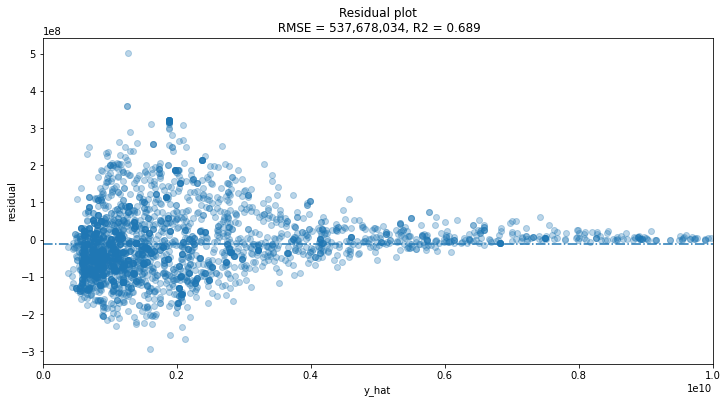

In [173]:
{"tags": ["hide-input"]}

X = X[~high_influence_obs, :]
y = y[~high_influence_obs]
Z = X[:, [2, 3]] # Variables responsible for heteroscedacity
# Robust Regression
reg = HetRobustRegression(fit_intercept=False)
results = reg.fit(X, y, Z)
r2 = results.score(X, y, Z)
y_hat = results.predict(X)
weight = results.weight_
weighted_resid = weight * (y - y_hat)
mse = mean_squared_error(y, y_hat, sample_weight=weight)
# matpltlib plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=y_hat, y=weighted_resid, alpha=0.3)
ax.axhline(y=weighted_resid.mean(), linestyle='-.')
ax.set_title(f'Residual plot\n RMSE = {np.sqrt(mse):,.0f}, R2 = {r2:.3f}')
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')
ax.set_xlim(0, 1e10)
plt.show()

Above residual plot shows that our dataset has a tolerated variability for house price no more than Rp. 5,000,000,000. It is suggested that the prediction is realible if the predicted house price is no more than Rp. 5,000,000,000.

Next, we will verify the confidence interval of regression coefficient.

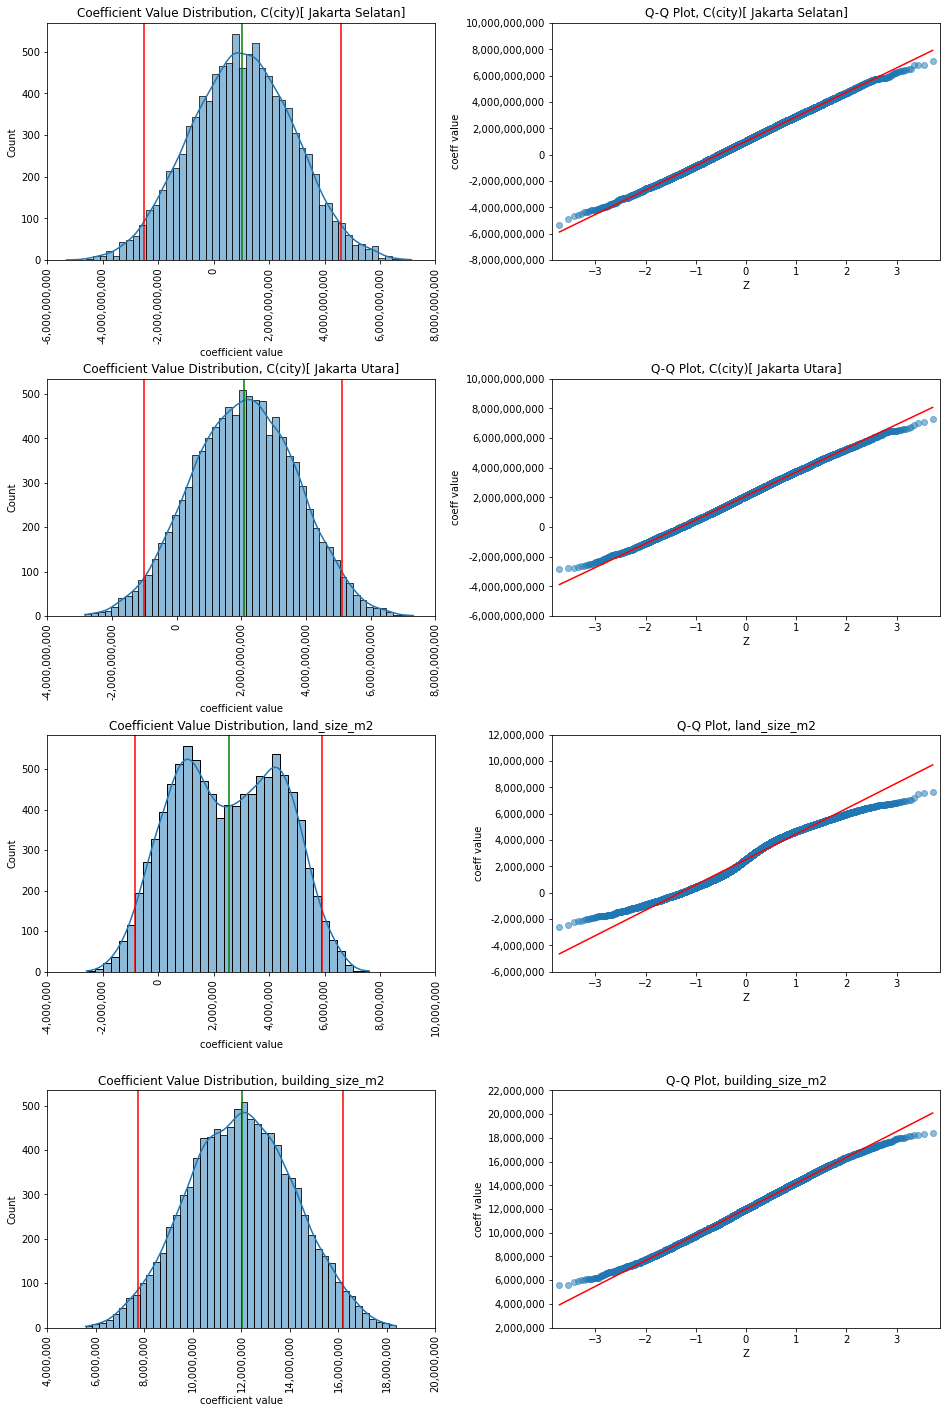

In [174]:
{"tags": ["hide-input"]}

from sklearn.linear_model import LinearRegression
from joblib import dump, load

def coefficient(x, y_null, boot_resid):
    epsilon = np.random.choice([1, -1], len(y_null), p=[0.5, 0.5]) # Flachair's pick distribution
    boot_resid_ = boot_resid.flatten()
    resid_dgp = boot_resid_ * epsilon
    y_dgp = (y_null + resid_dgp).flatten()
    lm_boots = LinearRegression(fit_intercept=False)
    result_boots = lm_boots.fit(x, y_dgp)
    coef_boots = result_boots.coef_
    return coef_boots

# prediction
lm = HetRobustRegression(fit_intercept=False)
results = lm.fit(X, y, Z)
dump(results, 'modules\\fitted_regressor.joblib') # store fitted regressor
y_predict = results.predict(X) # y_predict here serves beta as the null hypotheses for bootstrap
coef = results.coef_
# calculate hat matrix
h = np.diag(X @ np.linalg.inv((X.T) @ X) @ (X.T)) #  = h_t in Flachair (2003)
# calculate adjusted residual
residual = y - y_predict # = OLS restricted residuals in Flachair (2003)
a = 1/ (1 - h) # using HC3 as proposed by Flachair (2003)
resid = a * residual
adj_resid = resid - np.mean(resid)
# bootstrap ci
arr = np.empty(len(y))
sample = (arr, )
confidence_level = 0.95
lower_tail = (1 - confidence_level) / 2
upper_tail = 1 - lower_tail 
bootstrap_res = bootstrap(
    sample, lambda arr: coefficient(X, y_predict, adj_resid), vectorized=False, 
    confidence_level=confidence_level, method='percentile', n_resamples=9999
)
# Features
coef = coef.reshape(-1, 1)
features_name = features.values.reshape(-1, 1)
p = len(features_name)
# bootstrapping distribution
n_iter = 9999
arr = np.empty((n_iter, 1))
bootstrap_coeff_value = \
    np.apply_along_axis(lambda x: coefficient(X, y_predict, adj_resid), 1, arr)
# plotting bootstrap result
conf_low = bootstrap_res.confidence_interval[0].reshape(-1, 1)
conf_high = bootstrap_res.confidence_interval[1].reshape(-1, 1)
coef_array = np.c_[features_name, coef, conf_low, conf_high]
fig, ax = plt.subplots(p, 2, figsize=(16, 6 * p))

for index, (feature, coef_, ci_l_, ci_h_) in enumerate(coef_array):
    sns.histplot(
        x=bootstrap_coeff_value[:, index], kde=True, ax=ax[index, 0]
        )
    ax[index, 0].axvline(coef_, color='green')
    ax[index, 0].axvline(ci_l_, color='r')
    ax[index, 0].axvline(ci_h_, color='r')
    xticks = ax[index, 0].get_xticks()
    ax[index, 0].set_title(f'Coefficient Value Distribution, {feature}')
    ax[index, 0].set_xticks(xticks)
    ax[index, 0].set_xticklabels(['{:,.0f}'.format(x) for x in xticks], rotation=90)
    ax[index, 0].set_xlabel('coefficient value')
    # Q-Q Plot
    pplot = ProbPlot(bootstrap_coeff_value[:, index].flatten())
    pplot.qqplot(ax=ax[index, 1], alpha=0.5, line='s')
    yticks = ax[index, 1].get_yticks()
    ax[index, 1].set_yticks(yticks)
    ax[index, 1].set_yticklabels(['{:,.0f}'.format(y) for y in yticks])
    ax[index, 1].set_title(f'Q-Q Plot, {feature}')
    ax[index, 1].set_xlabel('Z')
    ax[index, 1].set_ylabel('coeff value')
plt.subplots_adjust(wspace=0.3, hspace=0.5)

From above confidence interval, except `building_size_m2`, in 95% confidence level there is evidence that the coefficients include 0 terms which mean, statistically, the variables is not useful to explains the linear relationship for house price.

So far, our weighted multiple regression parameters are explained as below:

In [175]:
{"tags": ["hide-input"]}

pd.DataFrame(
    coef_array,
    columns=['features_name', 'coef', 'conf_low', 'conf_high']
    ).set_index('features_name')

,coef,conf_low,conf_high
features_name,,,
C(city)[ Jakarta Selatan],"1,019,125,860.57","-2,518,970,214.40","4,594,527,235.28"
C(city)[ Jakarta Utara],"2,091,510,620.53","-1,008,794,806.16","5,125,033,441.57"
land_size_m2,"2,541,730.38","-844,952.51","5,907,015.76"
building_size_m2,"12,005,662.20","7,728,751.91","16,199,626.71"


# 3. Predictive Performance of Linear Model

In this section, we will assess our linear model's performance in generalizing house price for unknown data. We will use `test set` that is excluded in every analysis of our linear model building. This guarantees that there is no information leaked to our model.

We will compare all of the models that has been developed: 1) Simple OLS, 2) Simple WLS, 3) Multiple OLS, 4) Multiple WLS. We will also create a transformer function to detect and remove outliers so that each of the model has equal outliers treatment.

Note that our data has a tolerated variability for house price no more than Rp. 5,000,000,000 so let's consider this as the maximum value to be predicted.

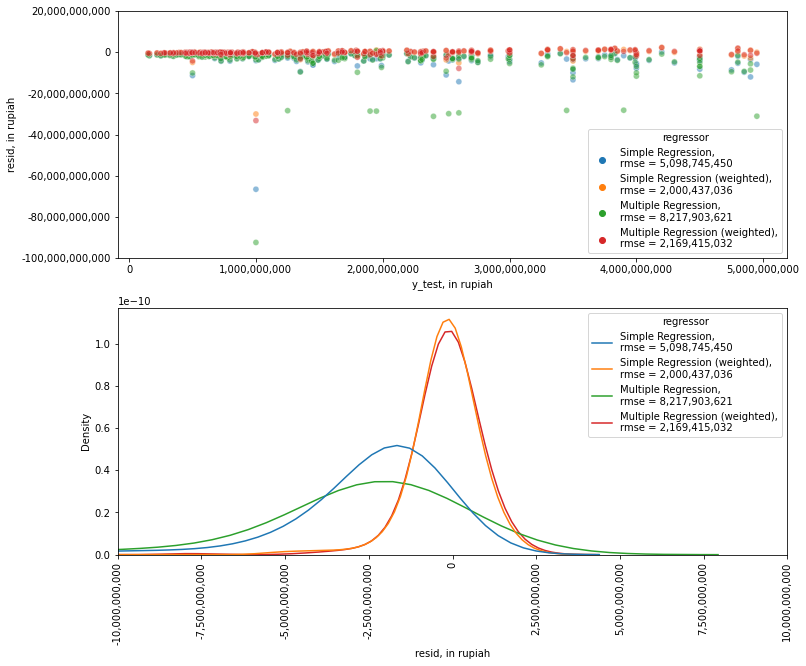

In [190]:
{"tags": ["hide-input"]}

from patsy import dmatrix
import seaborn as sns

def transform_set(X):
    high_pvalue_features = [
        'fac_tempat_jemuran', 'fac_jogging_track', 'fac_jalur_telepon', 'fac_jogging_track', 'fac_masjid', 
        'fac_cctv', 'fac_kitchen_set', 'fac_playground', 'fac_wastafel', 'fac_ac', 'fac_lapangan_bola', 
        'fac_mesin_cuci', 'fac_lapangan_bulu_tangkis', 'fac_kulkas', 'fac_water_heater', 'fac_smart_home', 
        'fac_backyard_luas', 'fac_garasi', 'fac_balkon', 'fac_clubhouse', 'fac_service_area', 'fac_plumbing_system',
        'maid_bathrooms', 'maid_bedrooms', 'electricity_num', 'fac_kolam_renang'
    ]
    noise_features = [
        'fac_one_gate_system', 'fac_tempat_gym', 'fac_kolam_ikan', 'fac_lapangan_voli', 'carports', 'garages',
        'fac_lapangan_basket', 'fac_lapangan_tenis', 'fac_akses_parkir', 'fac_canopy'
    ]
    numerical_features = \
        X_train.select_dtypes(exclude=['object', 'category'])\
            .drop(high_vif_features, axis=1)\
            .drop(high_pvalue_features, axis=1)\
            .drop(noise_features, axis=1).columns
    f = ' + '.join(numerical_features) + ' - 1 + '
    f += 'C(city)'
    X_transfd = dmatrix(f, X, return_type='dataframe')
    X_transfd = X_transfd.drop(X_transfd.columns[[0, 1, 2, 3, 4, 6, 8]], axis=1)
    return X_transfd

def remove_outliers(X, y):
    """ For OLS only"""
    I = np.identity(len(y))
    H = X @ np.linalg.inv((X.T) @ X) @ (X.T)
    p = X.shape[1]
    resid = (I - H) @ y
    se2 = np.square(np.linalg.norm(resid)) / (len(y) - p)
    # leverage is (weighted) hat matrix diagonal
    h = np.diag(H)
    cooks_dist = (np.square(resid) / (p * se2)) * (h / np.square(1 - h))
    high_influence_obs = (cooks_dist >= (3 / (X.shape[0] - p)))
    high_influence_obs_index = np.where(high_influence_obs)[0]
    return X[high_influence_obs_index, :], y[high_influence_obs_index ]

y_test = pd.read_csv('Dataset\y_test.csv').values
y_mask = (y_test < 5e9) # Setting constraint of our prediction to be < Rp. 5,000,000,000
X_test = pd.read_csv('Dataset\X_test.csv')[y_mask]
y_test = y_test[y_mask].flatten()
X_test = transform_set(X_test).values
Z_test = X_test[:, [2, 3]]
n_samples = len(y_test)
# prepared model
X_fit_simple = pd.read_csv('Dataset\X_train.csv')['building_size_m2'].values.reshape(-1, 1)
y_fit_simple = pd.read_csv('Dataset\y_train.csv').values
X_fit_multiple = transform_set(pd.read_csv('Dataset\X_train.csv')).values
y_fit_multiple = pd.read_csv('Dataset\y_train.csv').values
X_fit_simple, y_fit_simple = remove_outliers(X_fit_simple, y_fit_simple)
X_fit_multiple, y_fit_multiple = remove_outliers(X_fit_multiple, y_fit_multiple)
regressor_1 = OLS(y_fit_simple, X_fit_simple).fit() # single regressor using `building_size_m2`
regressor_2 = lm_2b # single regressor (weighted) using `building_size_m2`
regressor_3 = OLS(y_fit_multiple, X_fit_multiple).fit() # multiple regressor, [y, X] from train set
regressor_4 = results # weighted multiple regressor
# predict
y_test_pred_1 = regressor_1.predict(X_test[:, 3]).reshape(-1, 1)
y_test_pred_2 = regressor_2.predict(X_test[:, 3].reshape(-1, 1)).reshape(-1, 1)
y_test_pred_3 = regressor_3.predict(X_test).reshape(-1, 1)
y_test_pred_4 = regressor_4.predict(X_test).reshape(-1, 1)
# residual
resid_test_1 = (y_test.reshape(-1, 1) - y_test_pred_1)
resid_test_2 = (y_test.reshape(-1, 1) - y_test_pred_2)
resid_test_3 = (y_test.reshape(-1, 1) - y_test_pred_3)
resid_test_4 = (y_test.reshape(-1, 1) - y_test_pred_4)
# mse
rmse_test_1 = np.sqrt(mean_squared_error(y_test, y_test_pred_1.flatten()))
rmse_test_2 = np.sqrt(mean_squared_error(y_test, y_test_pred_2.flatten()))
rmse_test_3 = np.sqrt(mean_squared_error(y_test, y_test_pred_3.flatten()))
rmse_test_4 = np.sqrt(mean_squared_error(y_test, y_test_pred_4.flatten()))
# create df
resid_test_1 = \
    np.c_[
    y_test.reshape(-1, 1),
    y_test_pred_1, 
    resid_test_1, 
    np.repeat([f'Simple Regression,\nrmse = {rmse_test_1:,.0f}'], 
    n_samples).reshape(-1, 1)]
resid_test_2 = \
    np.c_[
    y_test.reshape(-1, 1),
    y_test_pred_2, 
    resid_test_2, 
    np.repeat([f'Simple Regression (weighted),\nrmse = {rmse_test_2:,.0f}'], 
    n_samples).reshape(-1, 1)]
resid_test_3 = \
    np.c_[
    y_test.reshape(-1, 1),
    y_test_pred_3, 
    resid_test_3, 
    np.repeat([f'Multiple Regression,\nrmse = {rmse_test_3:,.0f}'], 
    n_samples).reshape(-1, 1)]
resid_test_4 = \
    np.c_[
    y_test.reshape(-1, 1),    
    y_test_pred_4, 
    resid_test_4, 
    np.repeat([f'Multiple Regression (weighted),\nrmse = {rmse_test_4:,.0f}'], 
    n_samples).reshape(-1, 1)]

resid_df = pd.DataFrame(
    np.r_[resid_test_1, resid_test_2, resid_test_3, resid_test_4],
    columns=['y_test', 'y_pred', 'resid', 'regressor']
    )
resid_df = resid_df.assign(
    y_test = pd.to_numeric(resid_df.y_test),
    y_pred=pd.to_numeric(resid_df.y_pred),
    resid=pd.to_numeric(resid_df.resid)
    )
# plot
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
sns.scatterplot(
    data=resid_df, x='y_test', y='resid', ax=ax[0], hue='regressor', alpha=0.5
    )
sns.kdeplot(
    data=resid_df, x='resid',
    hue='regressor', ax=ax[1]
    )
xticks_1 = ax[0].get_xticks()[1:-1]
ax[0].set_xticks(xticks_1)
ax[0].set_xticklabels(['{:,.0f}'.format(x) for x in xticks_1])
yticks = ax[0].get_yticks()
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(['{:,.0f}'.format(y) for y in yticks])
ax[0].set_xlabel('y_test, in rupiah')
ax[0].set_ylabel('resid, in rupiah')
ax[1].set_xlabel('resid, in rupiah')
ax[1].set_xlim(-1e10, 1e10)
xticks_2 = ax[1].get_xticks()
ax[1].set_xticks(xticks_2)
ax[1].set_xticklabels(['{:,.0f}'.format(x) for x in xticks_2], rotation=90)
plt.show()

From above figure, it is clear that the OLS is biased (even after removing the high-influence observations!). The distribution of WLS is somewhat more-normal than the OLS. Note that we plot raw (non-weighted) residuals here. We can also see some of the observations that are predicted poorly by the OLS but WLS gives good results.

Simple WLS is a bit more superior than multiple regression here. The result is similar, which possibly proves the confidence interval of multiple regression's coefficients that includes 0 term. But note that, for our next section, we prefer model with more predictor variables.

The RMSE also uses raw residual. However, the value is quite high but this is probably caused by the presence of unusual observations here that all of the model agreed upon. Let's see the summary statistics for those residuals:

In [191]:
{"tags": ["hide-input"]}

resid_test_1 = (y_test.reshape(-1, 1) - y_test_pred_1)
resid_test_2 = (y_test.reshape(-1, 1) - y_test_pred_2)
resid_test_3 = (y_test.reshape(-1, 1) - y_test_pred_3)
resid_test_4 = (y_test.reshape(-1, 1) - y_test_pred_4)
resid_df = pd.DataFrame(
    np.c_[resid_test_1, resid_test_2, resid_test_3, resid_test_4],
    columns=[
        'Simple Regression', 'Simple Regression (weighted)', 
        'Multiple Regression', 'Multiple Regression (weighted)'
        ],
    dtype='float'
)
resid_df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).T.rename(columns={'50%': 'median'}).T

,Simple Regression,Simple Regression (weighted),Multiple Regression,Multiple Regression (weighted)
count,284.00,284.00,284.00,284.00
mean,"-2,636,008,995.02","-310,386,221.08","-3,724,053,535.27","-268,599,296.45"
std,"4,372,181,548.81","1,979,699,159.02","7,338,596,286.50","2,156,522,970.10"
min,"-66,540,868,206.60","-29,980,747,102.80","-92,371,368,846.86","-33,178,245,911.41"
10%,"-4,626,578,998.99","-1,084,199,854.11","-5,564,749,963.78","-961,738,259.02"
25%,"-3,043,332,518.69","-471,357,578.39","-3,188,001,451.33","-398,732,472.37"
median,"-1,756,142,549.94","-175,744,611.45","-1,979,248,081.77","-174,567,156.44"
75%,"-1,151,489,929.69","203,762,752.22","-1,416,757,645.19","219,288,996.36"
90%,"-778,697,888.18","691,710,546.97","-1,047,140,400.36","708,342,579.92"
max,"147,547,907.60","2,341,155,173.83","818,892,903.29","2,266,224,842.65"


Weighted multiple regression seems a bit more accurate than weighted simple regression, the mean residual is closer to zero and the quantile range is narrower than weighted simple regression.

Although the RMSE is quite big, look at the distance between the `median` and the `quantiles`. Quantiles of weigthed multiple regression only differs from its median by at most $150,000,000$ (150 millions). Turns out the model performs well for unknown data.

# 4. Practical Usage of Parametric Model: Way to Maximize House-Selling Profit for Developer

## 4.1. Case Example

Suppose a fictitious case example for designing general parameter of housing project. The output is to find the solution to maximize house selling profit given the cost (budget) to build a house with several requirement. The objectives:

1. Determine the general (high-level) parameter about housing related to price sentiment of Jabodetabek that can be associated from mathematical model (in our case, linear equation).
2. Develop mathematical solution to find the optimal value of each parameter that can maximize profit, which comply with requirements/constraints that are determined by each division from developer team. 

Below explained some simple example of possible request/constraint to be explained/fulfilled:

1. *Project Division* determined that maximum budget of project cost specific for house production (regardless of how many house to build) is `Rp. 15,000,000,000 (15 billion rupiahs)`. `Production cost per unit` for several parameters is given in `unit_price.xlsx`. 
2. *Designer Division* determined that the `land size` shall be minimum `1.5 times of house footprint`. `Number of floors` shall be `no more than 2`. Building area for second floor is `generally 60% of footprint area`. Designer also requested to explain the designated `building size` that is popular among Jabodetabek household.
3. *Legal Division* can secure land price for several Jabodetabek area that is given in `land_cost.xlsx`. The spreadsheet also contains available (non-occupied) land area that can be fully provided for housing project.
4. *Marketing Division* requested to explain various possible pricing options such as: `average/standard price`, `promotion price`, and `optimistic full-profit price`.

## 4.2. Solution

#### **A. Assumption**

We interpret how `Jabodetabek household values house price` as the house price sentiment based on sample taken from third party website that contain listing of offered house price (new and used). Then by generalizing the house price using mathematical equation, we predict what is the average of house price given its characteristic. We can also estimate how much margin from average price until that price is categorized as `overpriced` or `underpriced`.

For the purpose of working this case, we assume that this sample `represents the true value of house price distribution`.

We also assume that every location is equally popular and demanding in term of marketing speculation, thus the selection of project location purely accounted by the price alone.

#### **B. General Parameters**

We already developed linear equation which its parameters are proven to be statistically significant as a generalization of Jabodetabek House Price sentiment.

The linear equation provides `conditional mean given x*`, i.e. average house price on its specific value of parameters. The selected equation can be written as:

$$house\;price = 2,541,730\;land\;size\;+\;12,005,662\;building\;size\;$$

Above equation is a base case of house price for house located in `Jakarta Barat, Jakarta Timur, Bekasi, Depok, Bogor`, `Tangerang`, suggests that the house price is generally typical between those locations.

For specific case where location is in `Jakarta Selatan`, the mean house price is elevated by Rp. 1,019,125,860.

For specific case where location is in `Jakarta Utara`, the mean house price is elevated by Rp. 2,091,510,620.

So, the equations:

$$house\;price=\begin{cases}
    2,541,730\;land\;size\;+\;12,005,662\;building\;size+1,019,125,860&\text{if in Jakarta Selatan}\\
    2,541,730\;land\;size\;+\;12,005,662\;building\;size+2,091,510,620&\text{if in Jakarta Utara}\\
    2,541,730\;land\;size\;+\;12,005,662\;building\;size&\text{for other Jabodetabek Area}\end{cases}$$

But as explained previously, our linear model performance is proven optimal only for predicting `price < Rp. 5,000,000,000`. This sets our linear model constraints.

So the general parameters are: 
1. `Land size`
2. `Building size`
3. `Location`, whether the house is specifically located in one of `Jakarta Selatan` or `Jakarta Utara`.

#### **B. Sentiment about Building Size**

Based on sample, we can observe popularity of building size based on its distribution:

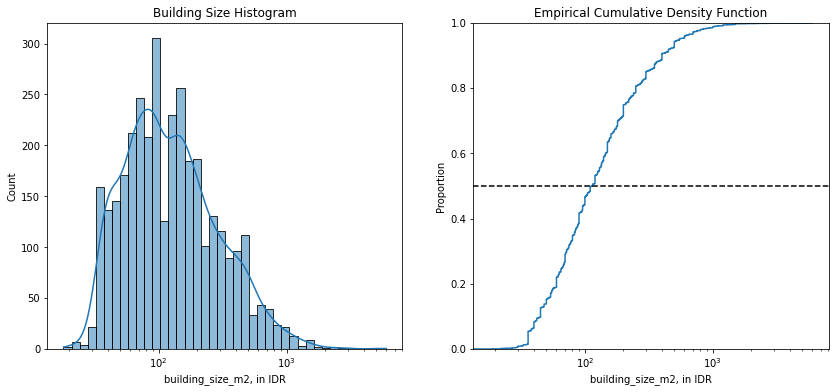

In [192]:
{"tags": ["hide-input"]}

house_df = pd.read_csv('Dataset\jabodetabek_house_data_prcsd.csv')
house_df.loc[house_df.city.str.contains('Jakarta'), 'city'] = ' DKI Jakarta'
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(
    data=house_df, x='building_size_m2', 
    kde=True, ax=ax[0], log_scale=True
    )
sns.ecdfplot(
    data=house_df, x='building_size_m2',ax=ax[1], log_scale=True
)
ax[0].set_title('Building Size Histogram')
ax[1].axhline(y=0.5, ls='--', color='black')
# ax[1].text(x=5*10e6, y=0.52, s=f'Proportion = 0.5,\nMedian={median:,.0f}')
ax[1].set_title('Empirical Cumulative Density Function')
for ax_ in ax:
    ax_.set_xlabel('building_size_m2, in IDR')

In [193]:
{"tags": ["hide-input"]}

house_df[['building_size_m2']].describe(percentiles=[0.25, 0.5, 0.75]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,25%,median,75%,max
building_size_m2,"3,443.00",186.96,249.52,18.00,67.00,113.00,205.00,"6,000.00"


If we interpert 50% percentile as the most popular building size, we found that around 100 m2 is quite popular. Suggested building size range based on above distribution may cover 25% and 75% percentile then:

$$building\;size = [60m^2,\;200m^2]$$

Furthermore, we can possibly inspect the building size pattern for each location using plot below:

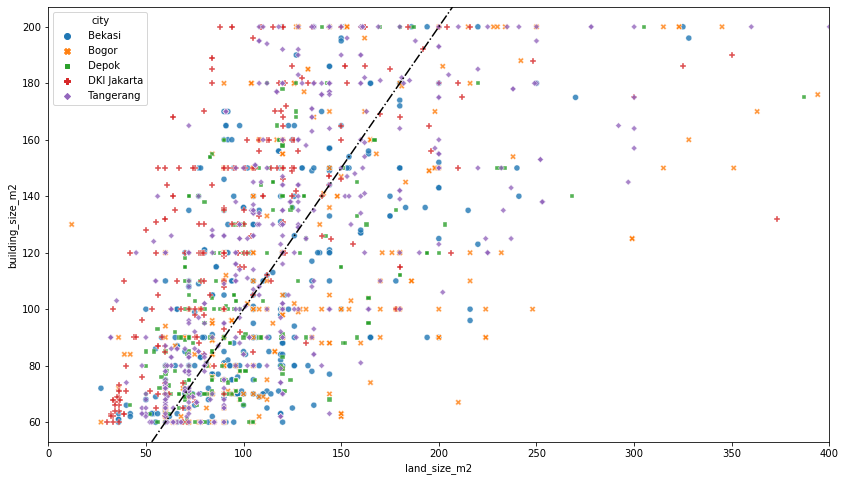

In [195]:
{"tags": ["hide-input"]}

fig, ax = plt.subplots(figsize=(14, 8))
building_size_filter = \
    np.logical_and(
        (house_df.building_size_m2 >= 60),
        (house_df.building_size_m2 <= 200)
        )
sns.scatterplot(
    data=house_df[building_size_filter],
    x='land_size_m2', y='building_size_m2', hue='city', style='city',
    ax=ax, alpha=0.8
)
ax.axline(xy1=(60, 60), xy2=(200, 200), color='black', ls='-.')
ax.set_xlim(0, 400)
plt.show()

Diagonal line with black color represents `building_size = land_size`, so observations that plotted above this line may suggest building with more than 1 floors.

Some distinguishable pattern:
1. Building size < $100\;m^2$ is quite popular in `Tangerang`
2. House that has more than 1 floor is popular in `DKI Jakarta`.
3. Possibly 1 floored house is popular in `Bogor`.

#### **C. Mathematical Problems to Solve**

Production cost of house alone is described as below:

In [196]:
{"tags": ["hide-input"]}

pd.read_excel('Dataset/unit_price.xlsx')

,work_item,variable,price,unit
0,land prep,land_size_m2,1000000,rp/m2
1,"house build, 1 floor",building_size_m2,4500000,rp/m2
2,"house build, 2 floor",building_size_m2,6000000,rp/m2


$$cost\;per\;house\;=\;land\;cost\;\times\;land\;size\;+\;1,000,000\;land\;size\;+\;(3,000,000\;+\;\;1,500,000\;floor)\;building\;size,$$
$$\\floor\;=\;[1,\;2]$$
$$house\;nos.\times\;cost\;per\;house\leq\;15,000,000,000$$

Where land size and building size subjects of each a house to be constructed.

Land price per meter square and the available area are as below:

In [197]:
{"tags": ["hide-input"]}

pd.read_excel('Dataset/land_price.xlsx')

,no,location,city,price_per_m2,available_area_m2
0,1,bogor_1,Bogor,1200000,600
1,2,bogor_2,Bogor,900000,650
2,3,bogor_3,Bogor,2000000,1000
3,4,bogor_4,Bogor,1000000,800
4,5,bogor_5,Bogor,2000000,500
5,6,depok_1,Depok,800000,300
6,7,depok_2,Depok,700000,400
7,8,depok_3,Depok,900000,600
8,9,jakut_1,Jakarta Utara,10000000,100
9,10,jakut_2,Jakarta Utara,8000000,150


$$land\;size\;\times\;house\;nos.\;\leq\;available\;area$$

Following `Designer Division` requirement regarding to land size:

$$land\;size\;\geq1.5\;building\;footprint$$

According to designer specification of first floor (footprint) and second floor (60% of footprint), so:

$$foot\;print=building\;size-(floor-1)\times\;0.6\times\;footprint$$

$$foot\;print=building\;size/(1+0.6(floor-1))$$

#### **D. Solution: Optimization Function**

Let variable of determining price-cost of house production be:

$$x_1=house\;nos.,\;x_2=land\;size,\;x_3\;=building\;size,\;x_4=floor,\;x_5=land\;cost$$

$$x_1\geq\;1$$

$$(x_2\;,x_3,\;x_5)>0$$



$$x_4 = 1\;or\;2$$

and location variables:

$$x_6=Jakarta\;Selatan,\;x_7=Jakarta\;Utara,$$
$$\;x_8=Tangerang,\;x_9=Bogor,\;x_{10}=Depok,\;x_{11}=Bekasi$$
$$x_{6..11} = 0\;or\;1$$

So we re-define the equation of project cost:

$$cost=x_1(x_5\times\;x_2+1,000,000\;x_2+(3,000,000+1,500,000\;x_4)x_3)$$

$$cost=x_1\times\;x_2\times\;x_5+1,000,000\;x_1\times\;x_2+3,000,000\;x_1\times\;x_3+1,500,000\;x_1\times\;x_3\times\;x_4$$

and expected price:

$$price=x_1(2,541,730\;x_2+12,005,663\;x_3+1,019,125,860\;x_6+1,019,125,860\;x_7)$$

so:

$$price=2,541,730\;x_1\times\;x_2+12,005,663\;x_1\times\;x_3$$
$$+1,019,125,860\;x_1\times\;x_6+1,019,125,860\;x_1\times\;x_7$$

This result in following mathematical problem then,

Find: $$x_1,\;x_2,\;x_3,\;x_4$$


given:
$$x_5,\;x_6,\;x_7,\;x_8$$

that maximize: 
$$y = price(x_1,\;x_2,\;x_3\;x_6,\;x_7,\;x_8) - cost(x_1,\;x_2,\;x_3,\;x_4,\;x_5)$$

or in other form, minimize (to suit with program that using algorithm to minimize cost function):
$$y* = cost(x_1,\;x_2,\;x_3,\;x_4,\;x_5) - price(x_1,\;x_2,\;x_3\;x_6,\;x_7,\;x_8)$$

with constraint:
$$cost(x_1,\;x_2,\;x_3,\;x_4,\;x_5)\leq\;(A=15,000,000,000)$$

$$price(x_1,\;x_2,\;x_3,\;x_4,\;x_5)/x_1\leq\;(B=5,000,000,000)$$

$$x_1\;\times\;x_2\leq\;A,\;where\;C=available\;area$$

$$x_2\;(1+0.6(x_4-1))\;/x_3>1.5$$

$$60\leq\;x_3\leq\;200$$

$$x_{1...5} > 0$$

We iterate along *x<sub>5</sub> (land price)* and its corresponding *C (available area)* to find the maximized profit for that location, then we will compare which has the most profit among others.

So we will create a python function with i/o: 

$$F(x_5, x_6, x_7, x_8, A, B, C)\rightarrow(x_1,x_2,x_3,x_4,\;cost,\;mean\;price, \;prediction\;interval)$$

Prediction interval here can be determined. We can use 1 times of `standard deviation of a distribution`, which explains *by how much, on average, the observations in that particular distribution differs from its own mean*. We then determine price tag for promotion (slightly lower price) or optimistic profit (slightly higher price), which then we select the price range by -1 to +1 times the standard deviation from mean price. The prediction interval will be determined as explained previously.

In [200]:
{"tags": ["hide-input"]}

from scipy.optimize import minimize
from scipy.stats import norm
from joblib import load

class OptimizeParameter:
    def __init__(self):
        self._fitted_regressor = load('modules\\fitted_regressor.joblib')
    
    @staticmethod
    def _price_func(target_vars, known_vars):
        # params = variable to estimate: x1, x2, x3, x4
        # Unpack params
        x1, x2, x3, x4 = target_vars
        x5, x6, x7, x8, x9, x10, x11 = known_vars
        # Price func
        price = \
            2541730.38 * x1 * x2\
                + 12005662.20 * x1 * x3\
                + 1019125860.57 * x1 * x6\
                + 2091510620.53 * x1 * x7
        return price

    @staticmethod
    def _cost_func(target_vars, known_vars):
        # params = variable to estimate: x1, x2, x3, x4
        # Unpack params
        x1, x2, x3, x4 = target_vars
        x5, x6, x7, x8, x9, x10, x11 = known_vars
        # cost func
        cost = \
            x1 * x2 * x5\
                + 1000000 * x1 * x2\
                + 3000000 * x1 * x3\
                + 1500000 * x1 * x3 * x4
        return cost

    def _obj_func(self, target_vars, known_vars):
        obj = \
            self._cost_func(target_vars, known_vars)\
                - self._price_func(target_vars, known_vars)
        return obj

    def _cost_const(self, target_vars, known_vars, A):
        # type = 'ineq' --> to be non-negative
        return (A - self._cost_func(target_vars, known_vars))
    
    def _x1_roundup_const(self, target_vars, roundup):
        # type = 'ineq' --> to be non-negative
        x1, x2, x3, x4 = target_vars
        # force the roundup value to be the allowed lowest value of x1
        # then try to optimize using x1 > roundup value
        return x1 - roundup
    
    def _x1_rounddown_const(self, target_vars, rounddown):
        # type = 'ineq' --> to be non-negative
        x1, x2, x3, x4 = target_vars
        # allow optimizer to search for x1 below lower bound
        # then try to optimize using x1 < lower bound
        return rounddown - x1

    def _price_const(self, target_vars, known_vars, B):
        # type = 'ineq' --> to be non-negative
        x1, x2, x3, x4 = target_vars
        return (B - (self._price_func(target_vars, known_vars) / x1))

    @staticmethod
    def _house_nos_const(target_vars):
        # type = 'ineq' --> to be non-negative
        x1, x2, x3, x4 = target_vars
        return (x1 - 1) 
 
    @staticmethod
    def _area_const(target_vars, C):
        # type = 'ineq' --> to be non-negative
        x1, x2, x3, x4 = target_vars
        return (C - x1 * x2)

    @staticmethod
    def _footprint_const(target_vars):
        x1, x2, x3, x4 = target_vars
        return (x2 * (1 + 0.6 * (x4 - 1)) / x3 - 1.5)

    @staticmethod
    def _min_build_size_const(target_vars):
        x1, x2, x3, x4 = target_vars
        return (x3 - 60)

    @staticmethod
    def _max_build_size_const(target_vars):
        x1, x2, x3, x4 = target_vars
        return (200 - x3)

    @staticmethod
    def _min_floor_const(target_vars):
        x1, x2, x3, x4 = target_vars
        return (x4 - 1)

    @staticmethod
    def _max_floor_const(target_vars):
        x1, x2, x3, x4 = target_vars
        return (2 - x4)

    @staticmethod
    def _nonzero_const_x1(target_vars):
        x1, x2, x3, x4 = target_vars
        return x1

    @staticmethod
    def _nonzero_const_x2(target_vars):
        x1, x2, x3, x4 = target_vars
        return x2

    @staticmethod
    def _nonzero_const_x3(target_vars):
        x1, x2, x3, x4 = target_vars
        return x3

    @staticmethod
    def _nonzero_const_x4(target_vars):
        x1, x2, x3, x4 = target_vars
        return x4

    def _get_pi(self, x, z, quantile=None, confidence_level=0.68):
        x_point = np.array(x).reshape(1, 4)
        z_point = np.array(z).reshape(1, 2)
        sigma2 = self._fitted_regressor.variance_
        weight = self._fitted_regressor.get_sample_weight(z_point)
        sigma2i = sigma2 * np.power(weight, -1)
        if confidence_level:
            interval = norm.interval(confidence_level)
        else:
            interval = norm.ppf(quantile)
        resid_lower = np.sqrt(sigma2i) * interval[0]
        resid_upper = np.sqrt(sigma2i) * interval[1]
        mean = self._fitted_regressor.predict(x_point)
        pi_low = mean + resid_lower
        pi_high = mean + resid_upper
        return (pi_low, pi_high)

    def _optimizer(self, known_vars, init_guess, constraint_dict):
        result = minimize(
            fun=lambda x: self._obj_func(x, known_vars), 
            x0=init_guess,
            method='COBYLA',
            constraints=constraint_dict,
            options={
                'maxiter':100000,
                'catol': 0.005
                }
            )
        return result


    def _verify_round_x1(
            self, known_vars, estimated_vars, x1_, 
            constraint, max_iter=1000):
        i = 0
        rounded_results = [None, None]
        rounded_obj = [0, 0]
        final_results = None
        final_obj = 0
        iter = 1
        while (rounded_results[0] != 0) & (rounded_results[1] != 0) & (x1_ > 1) & (iter <= max_iter):
            x1_down = np.floor(x1_ + i)
            x1_up = np.ceil(x1_ + i)
            const_down = constraint \
                + [{'type': 'ineq', 'fun': lambda x: self._x1_roundup_const(x, x1_down)}]\
                + [{'type': 'ineq', 'fun': lambda x: self._x1_rounddown_const(x, x1_down)}]
            const_up = constraint \
                + [{'type': 'ineq', 'fun': lambda x: self._x1_roundup_const(x, x1_up)}]\
                + [{'type': 'ineq', 'fun': lambda x: self._x1_rounddown_const(x, x1_up)}]
            rounded_results = [
                self._optimizer(known_vars, estimated_vars, const_down),
                self._optimizer(known_vars, estimated_vars, const_up)
                ]
            if rounded_results[0].success:
                rounded_obj[0] = self._obj_func(rounded_results[0].x, known_vars)
            if rounded_results[1].success:
                rounded_obj[1] = self._obj_func(rounded_results[1].x, known_vars)
            if not rounded_results[0].success:
                rounded_results[0] = 0
            if not rounded_results[1].success:
                rounded_results[1] = 0
            results = rounded_results[np.argmin(rounded_obj)]
            if np.argmin(rounded_obj) == 0:
                i -= 1
            else:
                i += 1
            obj = np.min(rounded_obj)
            if obj < final_obj:
                final_obj = obj
                final_results = results
            iter += 1
        if final_results:
            return final_results

    def _estimate_vars(self, known_vars, constraint, init_guess):
        """ 
        Estimate x1, x2, x3, x4 parameters.

        Parameters:
        ----------
        known_vars  : array size (n_samples, 1)
                      contains (x5, x6, x7, x8)
        constraint  : array size (n_samples, 1)
                      contains [A, B, C]
        init_guess  : array size (n_samples, 1)
                      Guess value of (x1, x2, x3, x4)
        Returns:
        --------
        Fitted object.
        """
        A, B, C = constraint
        const = [
            {'type': 'ineq', 'fun': lambda x: self._house_nos_const(x)},
            {'type': 'ineq', 'fun': lambda x: self._cost_const(x, known_vars, A)},
            {'type': 'ineq', 'fun': lambda x: self._price_const(x, known_vars, B)},
            {'type': 'ineq', 'fun': lambda x: self._area_const(x, C)},
            {'type': 'ineq', 'fun': lambda x: self._footprint_const(x)},
            {'type': 'ineq', 'fun': lambda x: self._min_build_size_const(x)},
            {'type': 'ineq', 'fun': lambda x: self._max_build_size_const(x)},
            {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x1(x)},
            {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x2(x)},
            {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x3(x)},
            {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x4(x)},
            {'type': 'ineq', 'fun': lambda x: self._min_floor_const(x)},
            {'type': 'ineq', 'fun': lambda x: self._max_floor_const(x)},
            ]
        result = self._optimizer(known_vars, init_guess, const)
        if result.success:
            estimated_vars = result.x
        else:
            print(f'Optimization Error for {known_vars}:\n{ValueError(result.message)}')
            print(result)
        obj = self._obj_func(estimated_vars, known_vars)
        # initiate rounding estimate
        upd_result = self._verify_round_x1(
            known_vars, estimated_vars, 
            estimated_vars[0], const
            )
        if upd_result:
            result = upd_result
        estimated_vars = result.x
        # calculate prediction interval
        x1, x2, x3, x4 = estimated_vars
        x5, x6, x7, x8 = known_vars[0:4]
        pi = self._get_pi(
            x=[x6, x7, x2, x3],
            z=[x2, x3]
            )
        # final result
        price = self._price_func(estimated_vars, known_vars)
        cost = self._cost_func(estimated_vars, known_vars)
        land_area = -(self._area_const(estimated_vars, 0))
        cost_per_house = cost / x1
        price_per_house = price / x1
        profit = price - cost
        pi_low = pi[0]
        pi_upper = pi[1]
        summary =  np.array([
            x1, x2, x3, x4, land_area,
            cost, cost_per_house,
            price, price_per_house,
            pi_low, pi_upper, profit
            ], dtype='object').reshape(1, 12)
        return summary

    def get_estimated_vars(
            self, known_vars, constraint, 
            init_guess, to_dataframe=True):
        """ 
        Estimate x1, x2, x3, x4 parameters.

        Parameters:
        ----------
        known_vars  : Array size (n_samples, 7)
                      contains (x5, x6, x7, x8, x9, x10, x11)
        constraint  : Array size (n_samples, 3)
                      or (1, 3) (broadcast to all samples)
                      contains [A, B, C]
        init_guess  : Array size (n_samples, 4)
                      or (1, 4) (broadcast to all samples)
                      Guess value of (x1, x2, x3, x4)
        Returns:
        --------
        Estimated parameters: DataFrame or array-like size (n_samples, 4)
        """
        if known_vars.shape[0] == constraint.shape[0]:
            params = np.c_[known_vars, constraint]
        else:
            params = np.c_[
                known_vars,
                np.broadcast_to(
                    constraint, (known_vars.shape[0], 3)
                    )
            ]
        if known_vars.shape[0] == init_guess.shape[0]:
            params = np.c_[params, init_guess]
        else:
            params = np.c_[
                params,
                np.broadcast_to(
                    init_guess, (known_vars.shape[0], 4)
                    )
            ]
        # Optimization Result.
        optimization_result = np.zeros((params.shape[0], 12))
        for i, param in enumerate(params):
            known_vars_ = param[:7]
            constraints_ = param[7:10]
            init_guess_ = param[10:14]
            result = self._estimate_vars(
                list(known_vars_), list(constraints_), list(init_guess_)
                )
            optimization_result[i, :] = result
        columns = [
            'house_nos.', 'house_land_size_m2', 'house_size_m2',
            'floor_nos', 'total_land_area', 'total_cost',
            'cost_per_house', 'total_price', 'house_price',
            'house_price_lower', 'house_price_upper','total_profit'
            ]
        if to_dataframe:
            return (pd.DataFrame(
                optimization_result, columns=columns
                )
            )
        return optimization_result

In [201]:
{"tags": ["hide-input"]}

land_price_df = pd.read_excel('Dataset/land_price.xlsx')
land_price_df = land_price_df.assign(
    x5=land_price_df.price_per_m2,
    x6=0, x7=0, x8 =0, x9 =0, x10 =0, x11=0,
    A=15000000000, B=5000000000, 
    C=land_price_df.available_area_m2
    )
label = {
    'x6': 'Jakarta Selatan', 
    'x7' : 'Jakarta Utara',
    'x8' : 'Tangerang',
    'x9' : 'Bogor',
    'x10' : 'Depok',
    'x11' : 'Bekasi'
    }
for key, value in label.items():
    land_price_df.loc[
        land_price_df.city == value,
        key] = 1
# setting up params
known_vars = land_price_df.iloc[:, 5:12].values
constraints = land_price_df.iloc[:, 12:15].values
init_guess = np.array([10, 60, 80, 2]).reshape(1, 4)
# optimization
results = OptimizeParameter().get_estimated_vars(known_vars, constraints, init_guess)
# show top 5 most profitable location
columns_to_show = list(land_price_df[['location', 'available_area_m2']].columns)\
    + list(results.columns)
summary_table = pd.merge(
    land_price_df, results, left_index=True, right_index=True
    )
summary_table[columns_to_show].sort_values('total_profit', ascending=False).head().T


,2,3,1,7,9
location,bogor_3,bogor_4,bogor_2,depok_3,jakut_2
available_area_m2,1000,800,650,600,150
house_nos.,14.00,10.00,9.00,6.00,2.00
house_land_size_m2,71.43,80.00,72.22,100.00,56.25
house_size_m2,76.19,85.33,77.04,106.67,60.00
floor_nos,2.00,2.00,2.00,2.00,2.00
total_land_area,"1,000.00",800.00,650.00,600.00,112.50
total_cost,"9,400,000,862.42","6,720,000,000.40","5,395,002,699.85","4,980,000,572.44","1,732,500,000.00"
cost_per_house,"671,428,633.03","672,000,000.04","599,444,744.43","830,000,111.35","866,250,000.00"
total_price,"15,347,771,799.89","12,278,216,048.80","9,976,055,941.25","9,208,662,959.95","5,909,645,372.81"


According to optimization result above, it can be seen that the *optimizer* prefers to maximize the number of houses to be produced, which tries to fully occupy the available land size. Interestingly, it also captures the potential profit of a small-sized area in `Jakarta Utara` given its predicted house price.

The specified `budget limit` seems a bit `overkills` if we consider the land specification of available locations. Above optimization result has found the maximum profit with total production cost only $Rp.\;9,400,000,862$. `Project Division` possibly would be happy with this finding!

The lower and upper price interval above explains the average deviation of house price from its average price, for specified land and building size. Take an example for lower price at `bogor_3`, we can interpret that most homeowner agree that  **type-76 house in Bogor** with price tag $653,756,484.96$  is below average (don't you think so?). But notice carefully that this is **below the production cost** and `Marketing Division` may select another price tag lower that than average price.

Also note that if we select the model that is `biased`, which is overestimating the house price in our case, we would possibly overestimate the profit and the *optimizer* would select the wrong potential location. Fortunately we avoided that situation by carefully analyzing our dataset's characteristics and applied the suitable model.

# 5. Closing

## 5.1. Conclusion

Above analysis shows that our dataset can be generalized by using Multiple Linear Regression Model, although Simple Linear Regression mostly gives comparable results.

For heterscedactic data, the Weighted Least Square is proven superior than ordinary least square to estimate slope coefficients. We should also select suitable inference method for this kind of data.

The purposefulness of linear model has been demonstrated in optimization function explained previously. Iterative process can be efficiently performed. Slight specification changes, which is common in project activity,  will affect insignificant development time and the result can be retrieved again quickly.


## 5.2. Further Improvement

There are always rooms for improvements. {cit:t}`atkinson2016` provides iterative *Forward Search* algorithm using WLS to detect outliers accurately.

Model tuning is also necessary to create model that generalize well with unknown data. For linear regression model, one can implement *Regularization Terms* to the linear model. *Ridge Regression* and *Lasso Regression* are well-known regression that implement some type of regularizations.

The representativeness of the dataset to estimate population of Jabodetabek House Price plays a major role in this analysis. Variability that presents in our dataset can be determined more accurately by providing more observations to our model. Data limitation that is explained above is purposed to demonstrate possible problems that could arise and how to handle them accordingly. And yes, *scraping program* that is presented in this repository can be used to expand the dataset.

# 6. References

```{bibliography}
:style: alpha
```